# Informe de análisis estadístico UNAV (seguimiento semana 2)

En este informe se van a realizar análisis sobre el conjunto de datos proporcioinado por la UNAV (DataSET_SF - V2.xlsx) ya unificado y preparado.

En este conjunto de datos se tiene un registro por oportunidad, siendo este el más reciente; es decir, para cada oportunidad se tiene su último estado.

El objetivo de este análisis es dar respuesta a preguntas que puedan resultar de valor para la UNAV y, que también nos permita detectar errores, tanto en la generación de los datos como en la unión de los mismos.

## Carga de los datos


In [2]:
import pandas as pd

# 1. Configuración de rutas y carga
ruta_salida = r"C:\Users\0017655\Downloads\dataset_tratamiento_final.csv"
datos_brutos = pd.read_csv(ruta_salida, sep=";", low_memory=False)

# 2. Definición de las variables necesarias según el Jupyter
# Sustituimos STAGENAME y PL_Subetapa por sus nombres reales en el CSV
variables_interes = [
    'ID', 
    'PL_Etapa__c',      # Sustituye a STAGENAME
    'PL_Subetapa__c',   # Sustituye a PL_Subetapa
    'target', 
    'prediction_label', 
    'prob_matricula_real',
    'etapa_ordinal_num' # Variable calculada necesaria para el orden
]

# 3. Filtrado de columnas y deduplicación
# Nos quedamos solo con las variables que existen en el conjunto de datos brutos
columnas_existentes = [col for col in variables_interes if col in datos_brutos.columns]
#datos_analisis = datos_brutos[columnas_existentes].copy()
datos_analisis = datos_brutos.copy()
# 4. Quedarse solo con la ÚLTIMA etapa por cada ID
# Asumimos que los datos vienen ordenados cronológicamente por fila. 
# Si existe una columna de fecha, lo ideal sería ordenar por ella antes.
datos_analisis = datos_analisis.drop_duplicates(subset=['ID'], keep='last')

# 5. Verificación
print(f"Registros originales: {len(datos_brutos)}")
print(f"Registros únicos (última etapa): {len(datos_analisis)}")
print(datos_analisis.head())

Registros originales: 536604
Registros únicos (última etapa): 70210
             ACCOUNTID                  ID            ID18__PC  target  \
5   001w000001X8jDhAAJ  0061r00000yz6vuAAA  003w000001knzGTAAY     0.0   
13  0011r00002Es7gpAAB  0061r000010lIlSAAU  0031r00002Wb8ieAAB     0.0   
14  0011r00001keBXpAAM  0061r000019zlReAAI  0031r000022f9OiAAI     0.0   
35  0011r00002P7oxhAAB  0061r00001CKKnpAAH  0031r00002iWi6jAAC     1.0   
38  0011r00002TWQvCAAX  0061r00001DdSqlAAF  0031r00002npmaAAAQ     0.0   

    desmatriculado PL_CURSO_ACADEMICO CH_NACIONAL  NU_NOTA_MEDIA_ADMISION  \
5              0.0          2022/2023        True                     NaN   
13             0.0          2022/2023        True                    4.57   
14             0.0          2023/2024        True                     NaN   
35             0.0          2022/2023        True                    6.20   
38             0.0          2022/2023        True                     NaN   

    NU_NOTA_MEDIA_1_BACH

## Análisis por origen de solicitud

1. ¿Hay matriculados con origen de solicitud: Solicitud de Información? ¿Tiene sentido? Cuantificar el número de oportunidades por origen de solicitud que se han matriculado o no se han matriculado.

2. ¿Cuánta información tienen las solicitudes de información y cuanta las solicitudes de admisión? ¿Tiene variables suficientes las solicitudes de información como para poder predecir la probabilidad de matrícula? ¿Debe filtrarse del conjunto de datos y trabajar sólo con las de admisión? ¿Qué variables tiene informadas las solicitudes de admisión? 

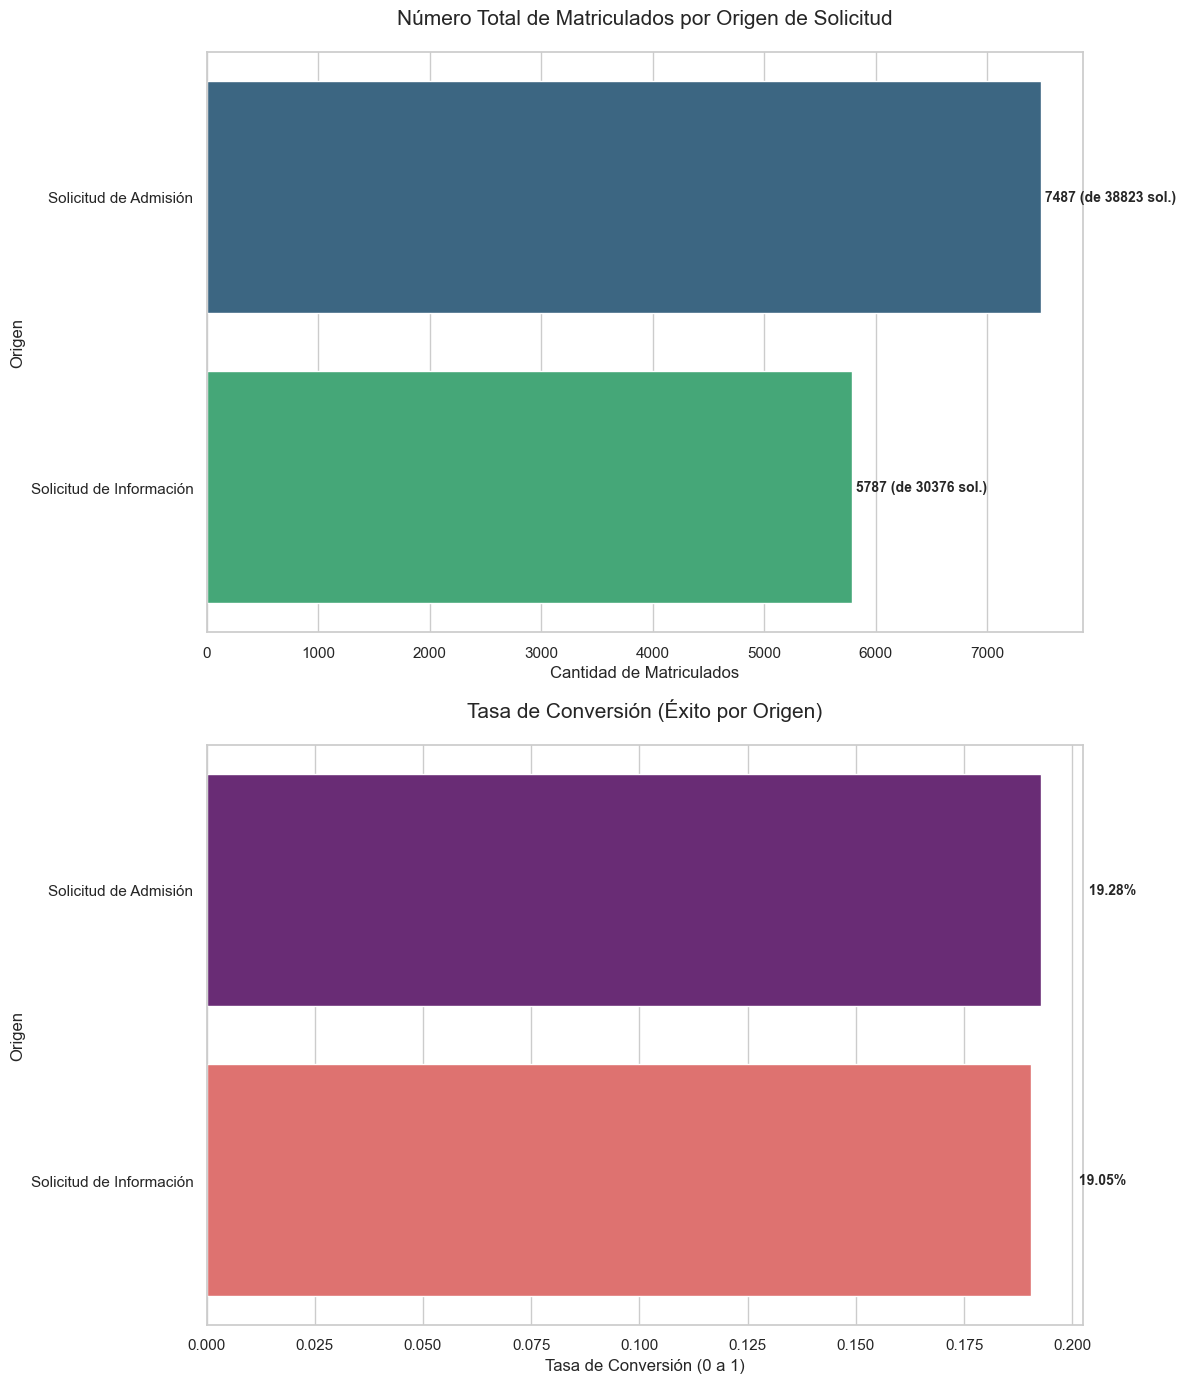

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuramos el estilo
sns.set_theme(style="whitegrid")

# 1. Preparar los datos
resumen = datos_analisis.groupby('PL_ORIGEN_DE_SOLICITUD')['target'].agg(['count', 'sum', 'mean']).reset_index()
resumen.columns = ['Origen', 'Total_Solicitudes', 'Matriculados', 'Tasa_Conversion']
resumen = resumen.sort_values(by='Matriculados', ascending=False)

# Crear la figura con dos subgráficos
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

# --- GRÁFICO 1: Volumen de Matriculados ---
# Añadimos hue='Origen' y legend=False para evitar el FutureWarning
plot1 = sns.barplot(
    data=resumen, 
    x='Matriculados', 
    y='Origen', 
    ax=axes[0], 
    palette='viridis', 
    hue='Origen', 
    legend=False
)
axes[0].set_title('Número Total de Matriculados por Origen de Solicitud', fontsize=15, pad=20)
axes[0].set_xlabel('Cantidad de Matriculados')

# Añadir etiquetas de datos
for i, bar in enumerate(plot1.patches):
    total_sol = resumen.iloc[i]['Total_Solicitudes']
    matriculados = resumen.iloc[i]['Matriculados']
    axes[0].text(matriculados + 0.1, bar.get_y() + bar.get_height()/2, 
                 f' {int(matriculados)} (de {int(total_sol)} sol.)', 
                 va='center', fontsize=10, fontweight='bold')

# --- GRÁFICO 2: Tasa de Conversión ---
resumen_tasa = resumen.sort_values(by='Tasa_Conversion', ascending=False)
# Añadimos hue='Origen' y legend=False aquí también
plot2 = sns.barplot(
    data=resumen_tasa, 
    x='Tasa_Conversion', 
    y='Origen', 
    ax=axes[1], 
    palette='magma', 
    hue='Origen', 
    legend=False
)
axes[1].set_title('Tasa de Conversión (Éxito por Origen)', fontsize=15, pad=20)
axes[1].set_xlabel('Tasa de Conversión (0 a 1)')

# Añadir etiquetas de porcentaje
for i, bar in enumerate(plot2.patches):
    tasa = resumen_tasa.iloc[i]['Tasa_Conversion']
    axes[1].text(tasa + 0.01, bar.get_y() + bar.get_height()/2, 
                 f' {tasa:.2%}', 
                 va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

Esto lo que nos sugiere es que hay casos en los que el origen de la solicitud es "Solicitud de información" y se han matriculado. Respecto a la información que nos facilitó la UNAV, no debería haber casos de Solicitud de información que se hayan matriculado porque pasar a la fase de admisión, dicho campo se actualiza directamente ¿es esto así?

In [4]:
# 1. Definimos las columnas que queremos visualizar
columnas_interes = [
    'ID', 
    'PL_ORIGEN_DE_SOLICITUD', 
    'PL_Etapa__c', 
    'PL_Subetapa__c', 
    'target', 
    'CU_precioOrdinario_def__c', 
    'CU_precioAplicado_def__c', 
    'PORCENTAJE_PAGADO_FINAL'
]

# 2. Definimos las condiciones de filtrado
condicion_solicitud = datos_analisis['PL_ORIGEN_DE_SOLICITUD'] == 'Solicitud de Información' 
condicion_matriculado = datos_analisis['target'] == 1

# 3. Filtramos el dataset aplicando AMBOS: filas (condiciones) y columnas (lista)
ejemplos_exito = datos_analisis.loc[condicion_solicitud & condicion_matriculado, columnas_interes]

# 4. Resultados
print(f"Se han encontrado {len(ejemplos_exito)} casos que cumplen ambas condiciones.")

if not ejemplos_exito.empty:
    # Mostramos 3 ejemplos aleatorios (o head(3) si prefieres los primeros)
    display(ejemplos_exito.sample(min(3, len(ejemplos_exito))))
else:
    print("No se encontraron registros con ambos criterios simultáneamente.")

Se han encontrado 5787 casos que cumplen ambas condiciones.


,ID,PL_ORIGEN_DE_SOLICITUD,PL_Etapa__c,PL_Subetapa__c,target,CU_precioOrdinario_def__c,CU_precioAplicado_def__c,PORCENTAJE_PAGADO_FINAL
176335,0066900001dFppeAAC,Solicitud de Información,Matrícula OOGG,Formalizada,1.0,NaN,NaN,NaN
228206,0066900001g4UtSAAU,Solicitud de Información,Matrícula OOGG,Formalizada,1.0,NaN,NaN,NaN
382854,006Tr00000DPk3PIAT,Solicitud de Información,Matrícula OOGG,Formalizada,1.0,14400.0,14400.0,100.0


En el ejemplo que hemos sacado se pueden ver casos en los que la matrícula está formalizada, y el origen de solicitud sigue como 'Solicitud de información'.

## Análisis de los desmatriculados

En este apartado, se va a realizar un análisis de los desmatriculados. Intentando dar respuesta a las siguientes preguntas:

1. ¿Qué titulaciones son las que tienen una mayor tasa de desmatriculación? (Número de desmatriculados entre oportunidades totales)

2. ¿Qué titulaciones son las que tienen un mayor número total de desmatriculados? ¿Cómo se distribuyen las notas finales de admisión para esas carreras entre matriculados y no matriculados? ¿Hay diferencia en las notas de admisión entre los alumnos matriculados y desmatriculados según el plazo de admisión?


Para ello, lo primero que mostramos es el gráfico de las titulaciones con mayor tasa de desmatriculaciones:

--- ANÁLISIS GLOBAL ---
Total de registros: 70210
Total desmatriculados: 1495.0
Porcentaje de desmatriculaciones: 2.13%
------------------------------


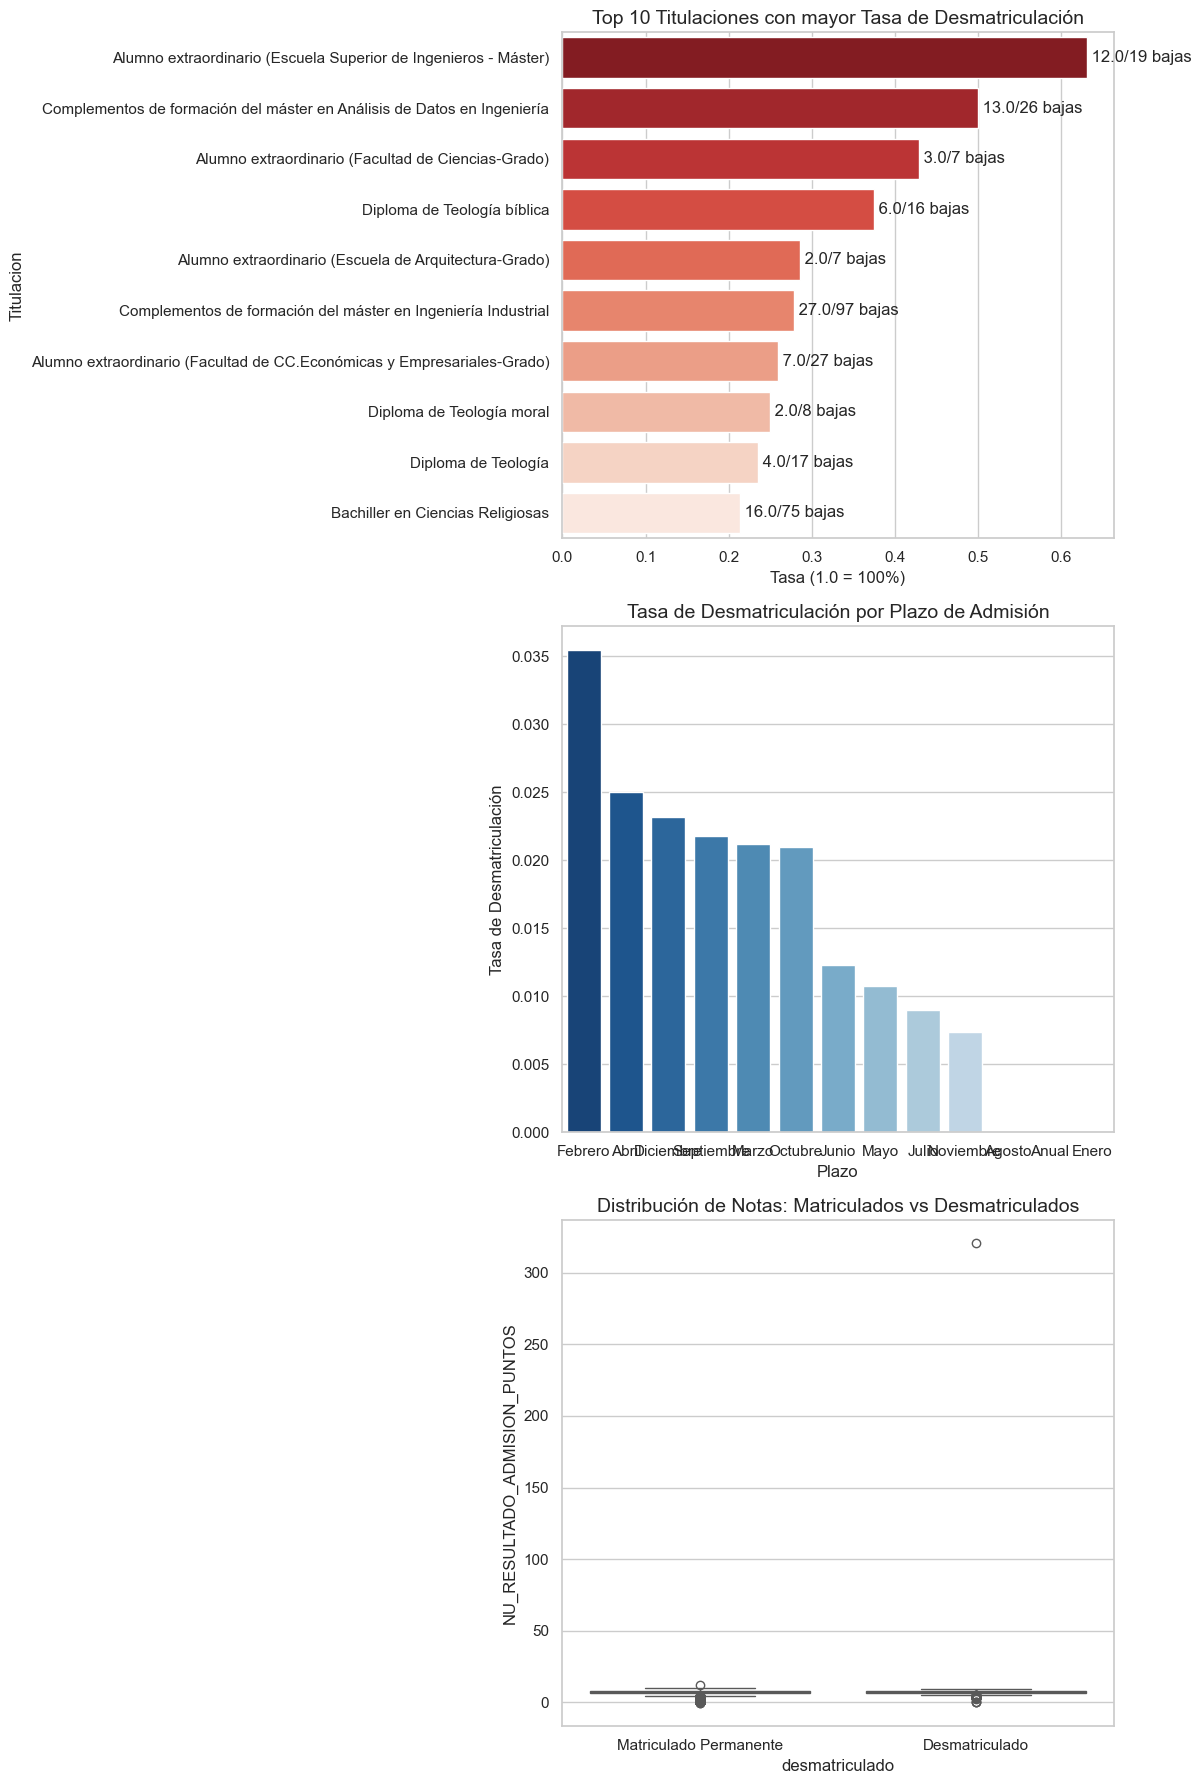


--- TABLA RESUMEN POR PLAZO ---
     Plazo  Total  Bajas     Tasa
   Febrero   4881  173.0 0.035444
     Abril   9779  245.0 0.025054
 Diciembre  18051  418.0 0.023157
Septiembre    275    6.0 0.021818
     Marzo  11982  254.0 0.021198
   Octubre   7197  151.0 0.020981
     Junio   3325   41.0 0.012331
      Mayo   3157   34.0 0.010770
     Julio   3217   29.0 0.009015
 Noviembre    136    1.0 0.007353
    Agosto      3    0.0 0.000000
     Anual      1    0.0 0.000000
     Enero    140    0.0 0.000000


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuramos el estilo visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 16)

# =========================================================
# 1. ANÁLISIS GLOBAL
# =========================================================
total_casos = len(datos_analisis)
total_desmatriculados = datos_analisis['desmatriculado'].sum()
porcentaje_desmatriculados = (total_desmatriculados / total_casos) * 100

print(f"--- ANÁLISIS GLOBAL ---")
print(f"Total de registros: {total_casos}")
print(f"Total desmatriculados: {total_desmatriculados}")
print(f"Porcentaje de desmatriculaciones: {porcentaje_desmatriculados:.2f}%")
print("-" * 30)

# Preparar la figura
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# =========================================================
# 2. POR TITULACIÓN
# =========================================================
tit_stats = datos_analisis.groupby('TITULACION')['desmatriculado'].agg(['count', 'sum', 'mean']).reset_index()
tit_stats.columns = ['Titulacion', 'Total_Inscritos', 'Bajas', 'Tasa_Desmatriculacion']
tit_stats = tit_stats[tit_stats['Total_Inscritos'] > 5].sort_values(by='Tasa_Desmatriculacion', ascending=False).head(10)

# Corrección: hue='Titulacion' y legend=False
sns.barplot(data=tit_stats, x='Tasa_Desmatriculacion', y='Titulacion', ax=axes[0], 
            palette='Reds_r', hue='Titulacion', legend=False)
axes[0].set_title('Top 10 Titulaciones con mayor Tasa de Desmatriculación', fontsize=14)
axes[0].set_xlabel('Tasa (1.0 = 100%)')

for i, bar in enumerate(axes[0].patches):
    bajas = tit_stats.iloc[i]['Bajas']
    total = tit_stats.iloc[i]['Total_Inscritos']
    axes[0].text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {bajas}/{total} bajas', va='center')

# =========================================================
# 3. POR PLAZO DE ADMISIÓN
# =========================================================
plazo_stats = datos_analisis.groupby('PL_PLAZO_ADMISION')['desmatriculado'].agg(['count', 'sum', 'mean']).reset_index()
plazo_stats.columns = ['Plazo', 'Total', 'Bajas', 'Tasa']
plazo_stats = plazo_stats.sort_values(by='Tasa', ascending=False)

# Corrección: hue='Plazo' y legend=False
sns.barplot(data=plazo_stats, x='Plazo', y='Tasa', ax=axes[1], 
            palette='Blues_r', hue='Plazo', legend=False)
axes[1].set_title('Tasa de Desmatriculación por Plazo de Admisión', fontsize=14)
axes[1].set_ylabel('Tasa de Desmatriculación')

# =========================================================
# 4. NOTAS DE ADMISIÓN
# =========================================================
# Corrección: hue='desmatriculado' y legend=False
sns.boxplot(data=datos_analisis, x='desmatriculado', y='NU_RESULTADO_ADMISION_PUNTOS', ax=axes[2], 
            palette='Set2', hue='desmatriculado', legend=False)
axes[2].set_title('Distribución de Notas: Matriculados vs Desmatriculados', fontsize=14)

# Corrección moderna para etiquetas de eje
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Matriculado Permanente', 'Desmatriculado'])

plt.tight_layout()
plt.show()

# Mostrar tabla resumen
print("\n--- TABLA RESUMEN POR PLAZO ---")
print(plazo_stats[['Plazo', 'Total', 'Bajas', 'Tasa']].to_string(index=False))

Aquí podemos observar lo siguiente:

1. Las titulaciones que tienen una mayor tasa de desmatriculación es debido a que tiene muy pocas oportunidades asociadas, por lo que en una variación pequeña de las desmatriculaciones, hay un aumento muy grande de la tasa.

2. Podemos ver que las tasas de desmatriculaciones son más altas en febrero, aunque en diciembre hay más desmatriculaciones, pero al haber más oportunidades, la tasa es menor.

A continuación, se muestra un gráfico de la distribución de notas de admisiñon entre matriculados y no matriculados.

No se ve una diferencia significativa en las notas de matriculados y no matriculados.

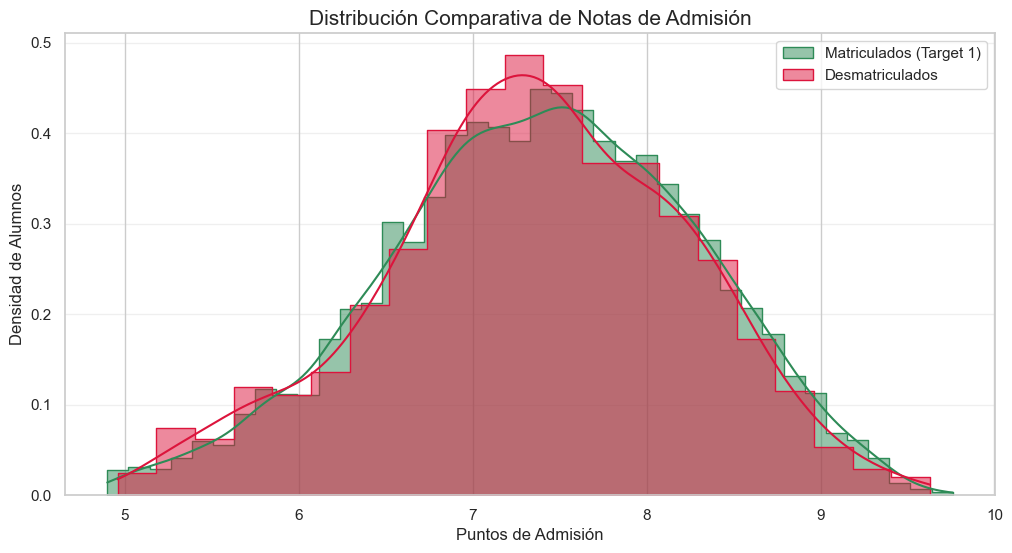

Media de nota (Matriculados): 7.39
Media de nota (Desmatriculados): 7.35
Diferencia real: 0.04 puntos


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preparar los grupos (Filtrado estricto)
# Grupo Matriculados: target=1 y no se han ido
# Grupo Desmatriculados: los que tienen la marca de desmatriculado
df_mat = datos_analisis[(datos_analisis['target'] == 1) & (datos_analisis['desmatriculado'] == 0)].copy()
df_des = datos_analisis[datos_analisis['desmatriculado'] == 1].copy()

# 2. Función para limpiar outliers (IQR)
def limpiar_outliers(df, col):
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    return df[(df[col] >= (q1 - 1.5 * iqr)) & (df[col] <= (q3 + 1.5 * iqr))]

# Limpiamos ambos datasets por separado
df_mat_clean = limpiar_outliers(df_mat.dropna(subset=['NU_RESULTADO_ADMISION_PUNTOS']), 'NU_RESULTADO_ADMISION_PUNTOS')
df_des_clean = limpiar_outliers(df_des.dropna(subset=['NU_RESULTADO_ADMISION_PUNTOS']), 'NU_RESULTADO_ADMISION_PUNTOS')

# 3. Gráfico de Distribución (Histograma + KDE)
plt.figure(figsize=(12, 6))

# Distribución Matriculados
sns.histplot(df_mat_clean['NU_RESULTADO_ADMISION_PUNTOS'], 
             color="seagreen", label="Matriculados (Target 1)", 
             kde=True, stat="density", alpha=0.5, element="step")

# Distribución Desmatriculados
sns.histplot(df_des_clean['NU_RESULTADO_ADMISION_PUNTOS'], 
             color="crimson", label="Desmatriculados", 
             kde=True, stat="density", alpha=0.5, element="step")

# Personalización
plt.title('Distribución Comparativa de Notas de Admisión', fontsize=15)
plt.xlabel('Puntos de Admisión')
plt.ylabel('Densidad de Alumnos')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()

# 4. Cálculo de la diferencia de medias
media_mat = df_mat_clean['NU_RESULTADO_ADMISION_PUNTOS'].mean()
media_des = df_des_clean['NU_RESULTADO_ADMISION_PUNTOS'].mean()
print(f"Media de nota (Matriculados): {media_mat:.2f}")
print(f"Media de nota (Desmatriculados): {media_des:.2f}")
print(f"Diferencia real: {abs(media_mat - media_des):.2f} puntos")

Como podéis observar, la tasa no nos ayuda a entender el problema de las desmatriculaciones, por lo que, se va a analizar las desmatriculaciones de forma total y no en tasa, analizándolo por titulación y plazo.


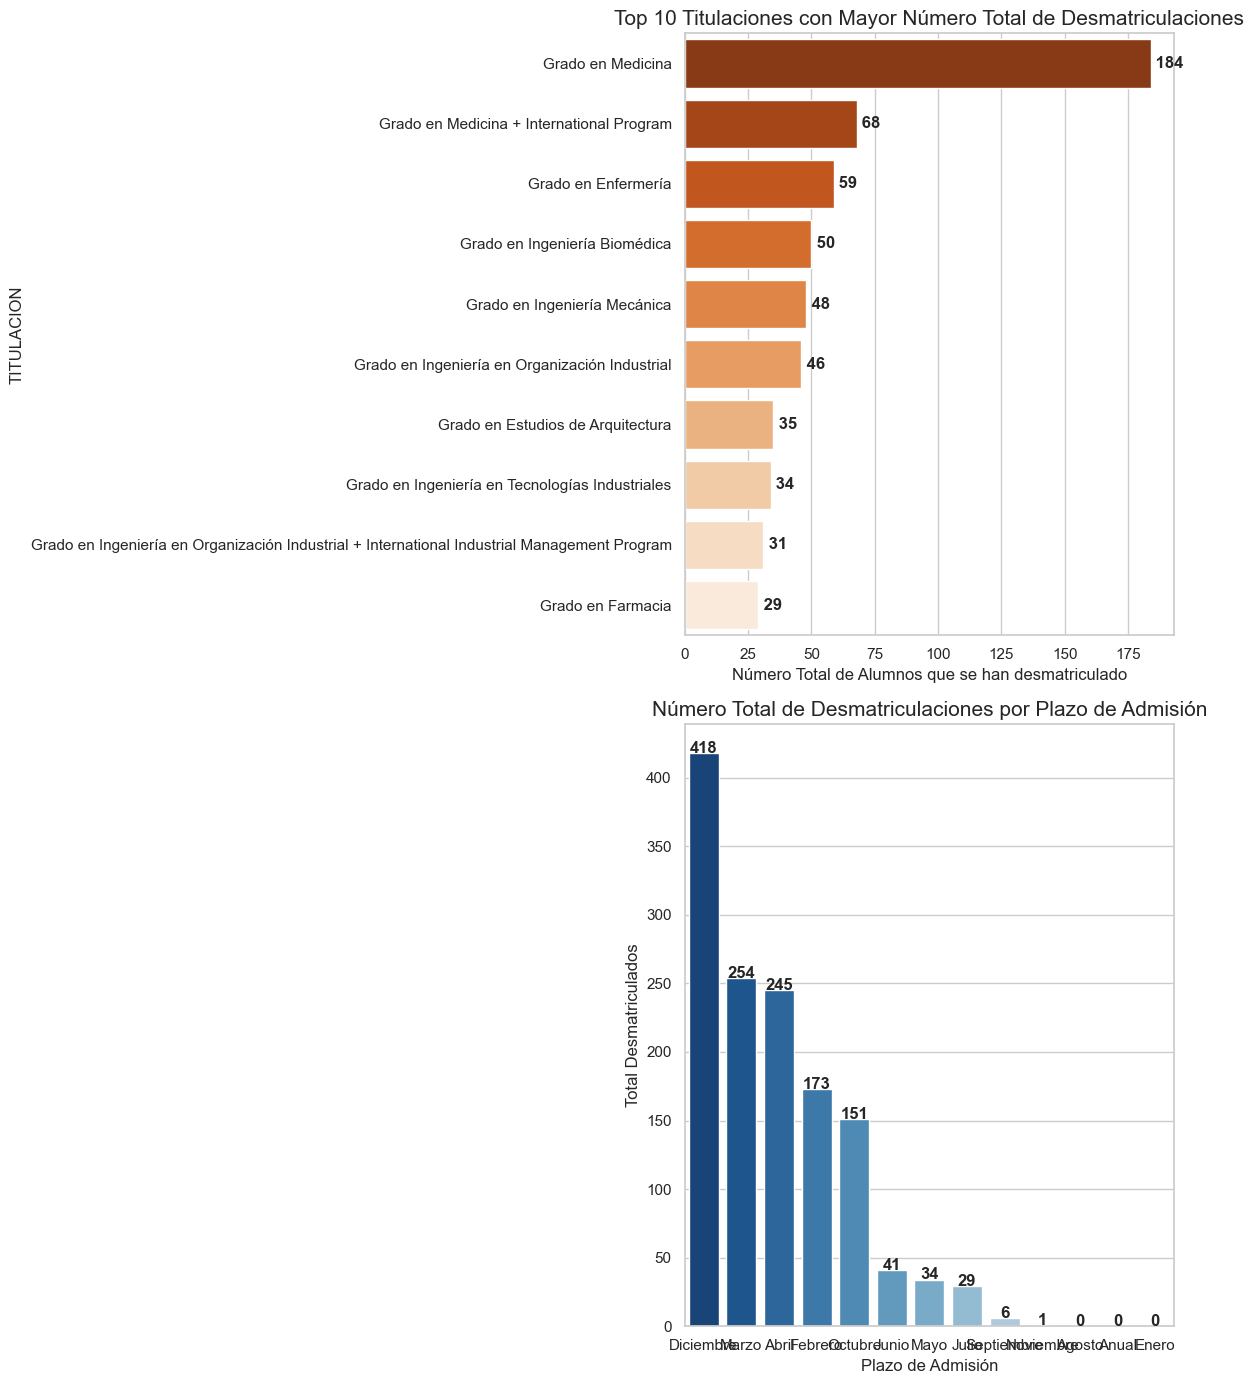

NÚMERO TOTAL DE DESMATRICULACIONES POR PLAZO:
---------------------------------------------
Plazo de Admisión  Total Desmatriculaciones
        Diciembre                     418.0
            Marzo                     254.0
            Abril                     245.0
          Febrero                     173.0
          Octubre                     151.0
            Junio                      41.0
             Mayo                      34.0
            Julio                      29.0
       Septiembre                       6.0
        Noviembre                       1.0
           Agosto                       0.0
            Anual                       0.0
            Enero                       0.0
---------------------------------------------
Total global de desmatriculaciones: 1352.0


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuramos el estilo
sns.set_theme(style="whitegrid")

# 1. Preparar datos por Titulación (Volumen total)
tit_bajas = datos_analisis.groupby('TITULACION')['desmatriculado'].sum().reset_index()
tit_bajas = tit_bajas.sort_values(by='desmatriculado', ascending=False).head(10)

# 2. Preparar datos por Plazo (Volumen total)
plazo_bajas = datos_analisis.groupby('PL_PLAZO_ADMISION')['desmatriculado'].sum().reset_index()
plazo_bajas = plazo_bajas.sort_values(by='desmatriculado', ascending=False)

# Crear la figura
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

# --- GRÁFICO 1: Volumen de Bajas por Titulación ---
# Corrección: hue='TITULACION' y legend=False
sns.barplot(
    data=tit_bajas, 
    x='desmatriculado', 
    y='TITULACION', 
    ax=axes[0], 
    palette='Oranges_r', 
    hue='TITULACION', 
    legend=False
)
axes[0].set_title('Top 10 Titulaciones con Mayor Número Total de Desmatriculaciones', fontsize=15)
axes[0].set_xlabel('Número Total de Alumnos que se han desmatriculado')

# Añadir etiquetas de valor
for i, bar in enumerate(axes[0].patches):
    valor = int(bar.get_width())
    axes[0].text(valor + 0.1, bar.get_y() + bar.get_height()/2, f' {valor}', va='center', fontweight='bold')

# --- GRÁFICO 2: Volumen de Bajas por Plazo de Admisión ---
# Corrección: hue='PL_PLAZO_ADMISION' y legend=False
sns.barplot(
    data=plazo_bajas, 
    x='PL_PLAZO_ADMISION', 
    y='desmatriculado', 
    ax=axes[1], 
    palette='Blues_r', 
    hue='PL_PLAZO_ADMISION', 
    legend=False
)
axes[1].set_title('Número Total de Desmatriculaciones por Plazo de Admisión', fontsize=15)
axes[1].set_ylabel('Total Desmatriculados')
axes[1].set_xlabel('Plazo de Admisión')

# Añadir etiquetas de valor
for i, bar in enumerate(axes[1].patches):
    valor = int(bar.get_height())
    axes[1].text(bar.get_x() + bar.get_width()/2, valor + 0.1, f'{valor}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# =========================================================
# CÁLCULO DE DESMATRICULACIONES POR PLAZO
# =========================================================

resumen_plazos = datos_analisis.groupby('PL_PLAZO_ADMISION')['desmatriculado'].sum().reset_index()
resumen_plazos = resumen_plazos.sort_values(by='desmatriculado', ascending=False)
resumen_plazos.columns = ['Plazo de Admisión', 'Total Desmatriculaciones']

print("NÚMERO TOTAL DE DESMATRICULACIONES POR PLAZO:")
print("-" * 45)
print(resumen_plazos.to_string(index=False))
print("-" * 45)
print(f"Total global de desmatriculaciones: {resumen_plazos['Total Desmatriculaciones'].sum()}")

En este caso, sí se ve que las carreras que engloban más desmatriculaciones son: *Medicina* (sin programa internacional y con programa internacional) y enfermería. También se puede ver, que los plazos de admisión que concentran más desmatriculaciones de forma global es diciembre.

A continuación, vamos a ver cómo se distribuyen las notas de admisión para las titulaciones que tienen más desmatriculados de forma global.

TABLA COMPARATIVA: TOP 5 TITULACIONES CON MÁS BAJAS


,Titulacion,Total_Matriculados,Nota_Media_Mat,Total_Desmatriculados,Nota_Media_Des
3,Grado en Medicina,556,7.13,184,7.24
4,Grado en Medicina + International Program,319,6.50,65,6.70
0,Grado en Enfermería,357,6.71,58,7.04
1,Grado en Ingeniería Biomédica,139,7.49,46,7.38
2,Grado en Ingeniería Mecánica,193,7.55,46,7.18


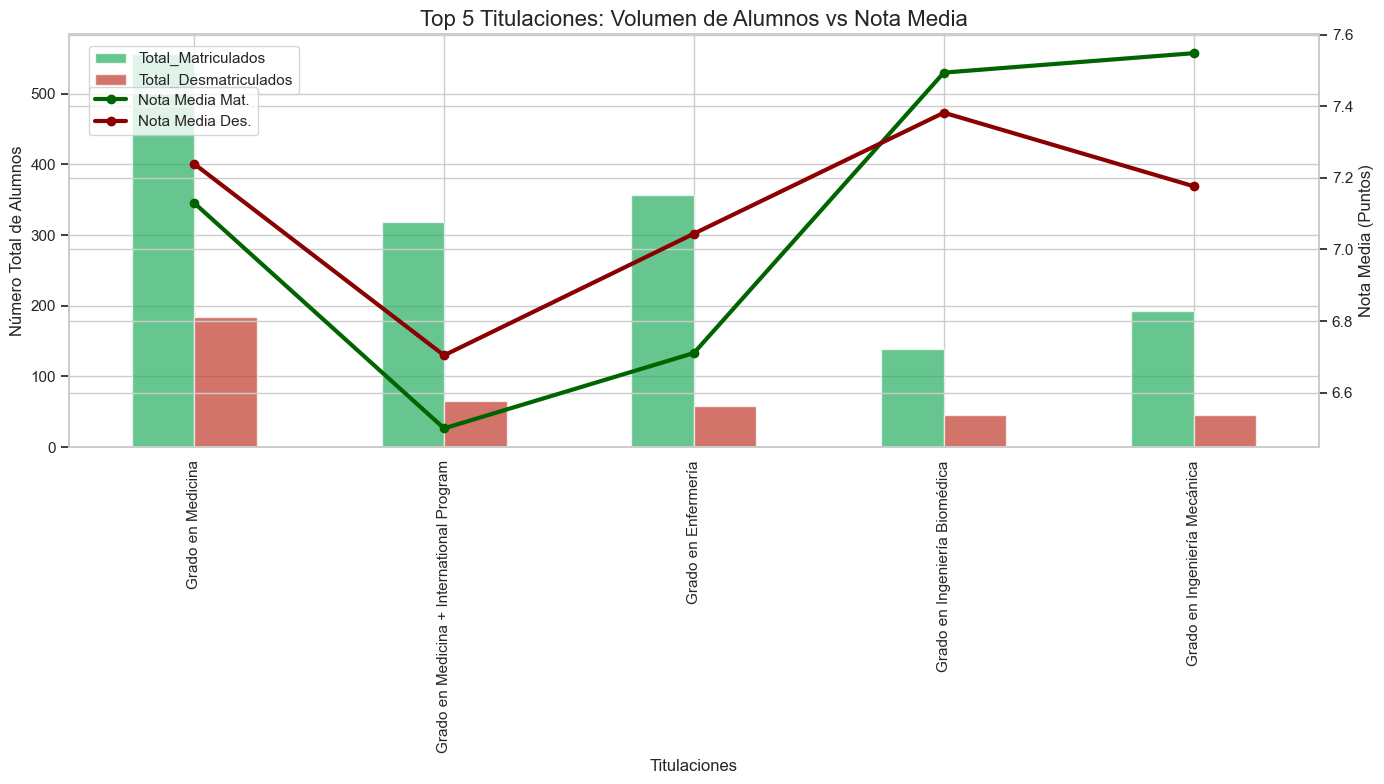

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Identificar las 5 titulaciones con más desmatriculados
top_5_titulaciones = datos_analisis.groupby('TITULACION')['desmatriculado'].sum().sort_values(ascending=False).head(5).index.tolist()

# 2. Filtrar el dataset solo para esas titulaciones y separar grupos
df_top5 = datos_analisis[datos_analisis['TITULACION'].isin(top_5_titulaciones)]

df_mat = df_top5[(df_top5['target'] == 1) & (df_top5['desmatriculado'] == 0)]
df_des = df_top5[df_top5['desmatriculado'] == 1]

# 3. Agrupar por Titulación para obtener Volumen y Nota Media
stats_mat = df_mat.groupby('TITULACION')['NU_RESULTADO_ADMISION_PUNTOS'].agg(['count', 'mean']).reset_index()
stats_des = df_des.groupby('TITULACION')['NU_RESULTADO_ADMISION_PUNTOS'].agg(['count', 'mean']).reset_index()

# Unir en tabla comparativa
resumen_tit = pd.merge(stats_mat, stats_des, on='TITULACION', how='outer', suffixes=('_Mat', '_Des')).fillna(0)
resumen_tit.columns = ['Titulacion', 'Total_Matriculados', 'Nota_Media_Mat', 'Total_Desmatriculados', 'Nota_Media_Des']
resumen_tit = resumen_tit.sort_values(by='Total_Desmatriculados', ascending=False)

# 4. Mostrar la Tabla
print("TABLA COMPARATIVA: TOP 5 TITULACIONES CON MÁS BAJAS")
display(resumen_tit.round(2))

# 5. Gráfico Combinado
fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()

# Barras para el número total de personas
resumen_tit.plot(x='Titulacion', y=['Total_Matriculados', 'Total_Desmatriculados'], 
                 kind='bar', ax=ax1, color=['#27ae60', '#c0392b'], alpha=0.7)

# Líneas para las notas medias
# Usamos el índice para posicionar los puntos sobre las barras
x_coords = range(len(resumen_tit))
ax2.plot(x_coords, resumen_tit['Nota_Media_Mat'], marker='o', color='darkgreen', label='Nota Media Mat.', linewidth=3)
ax2.plot(x_coords, resumen_tit['Nota_Media_Des'], marker='o', color='darkred', label='Nota Media Des.', linewidth=3)

# Configuración de ejes y títulos
ax1.set_title('Top 5 Titulaciones: Volumen de Alumnos vs Nota Media', fontsize=16)
ax1.set_ylabel('Número Total de Alumnos', fontsize=12)
ax2.set_ylabel('Nota Media (Puntos)', fontsize=12)
ax1.set_xlabel('Titulaciones', fontsize=12)

# Ajustar leyenda
ax1.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99))
ax2.legend(loc='upper left', bbox_to_anchor=(0.01, 0.89))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Aquí, se puede observar que las notas de admisión suelen ser ligeramente más altas entre los desmatriculados que en los matriculados en las carreras de Medicina y Enfermería, en cambio, ocurre lo contrario para Ingeniería Biomédica e Ingeniería Mecánica.

Por último se puede ver una tabla para comprobar las notas medias por plazo de admisión y por matriculados y no matriculados en las titulaciones con un mayor número de desmatriculados:

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Identificar las 5 titulaciones con más desmatriculados
top_5_titulaciones = datos_analisis.groupby('TITULACION')['desmatriculado'].sum().sort_values(ascending=False).head(5).index.tolist()

# 2. Filtrar y preparar los datos
df_top5 = datos_analisis[datos_analisis['TITULACION'].isin(top_5_titulaciones)].copy()

def definir_estado(row):
    if row['desmatriculado'] == 1:
        return 'Desmatriculado'
    elif row['target'] == 1:
        return 'Matriculado'
    return 'Otros'

df_top5['Estado'] = df_top5.apply(definir_estado, axis=1)
df_final = df_top5[df_top5['Estado'].isin(['Matriculado', 'Desmatriculado'])].copy()

# =================================================================
# LIMPIEZA DE NAs EN NOTAS
# =================================================================
# Eliminamos filas donde la nota de admisión sea NaN
df_final = df_final.dropna(subset=['NU_RESULTADO_ADMISION_PUNTOS'])

# Opcional: Eliminar también filas donde el Plazo sea NaN si fuera necesario
df_final = df_final.dropna(subset=['PL_PLAZO_ADMISION'])
# =================================================================

# 3. ANÁLISIS EN TABLA: Nota media
# Usamos dropna() en el groupby para evitar filas de NAs en la tabla
tabla_detalle = df_final.groupby(['TITULACION', 'PL_PLAZO_ADMISION', 'Estado'])['NU_RESULTADO_ADMISION_PUNTOS'].mean().unstack().round(2)

print("NOTA MEDIA: MATRICULADOS VS DESMATRICULADOS POR PLAZO Y TITULACIÓN (Sin NaNs)")
display(tabla_detalle)


NOTA MEDIA: MATRICULADOS VS DESMATRICULADOS POR PLAZO Y TITULACIÓN (Sin NaNs)


Estado                                                       Desmatriculado  \
TITULACION                                PL_PLAZO_ADMISION                   
Grado en Enfermería                       Abril                        6.89   
                                          Diciembre                    7.60   
                                          Febrero                       NaN   
                                          Marzo                        6.88   
Grado en Ingeniería Biomédica             Abril                        7.62   
                                          Diciembre                    7.67   
                                          Febrero                      7.19   
                                          Junio                         NaN   
                                          Marzo                        7.31   
                                          Mayo                         6.12   
Grado en Ingeniería Mecánica              Abril                        6.82   
                                          Diciembre                    7.48   
                                          Febrero                      7.06   
                                          Julio                        7.68   
                                          Junio                        0.00   
                                          Marzo                        7.55   
                                          Mayo                         8.03   
Grado en Medicina                         Abril                        7.12   
                                          Febrero                       NaN   
                                          Marzo                        7.35   
Grado en Medicina + International Program Abril                        7.06   
                                          Diciembre                    4.64   
                                          Febrero                      4.27   
                                          Marzo                        7.39   

Estado                                                       Matriculado  
TITULACION                                PL_PLAZO_ADMISION               
Grado en Enfermería                       Abril                     6.49  
                                          Diciembre                 7.14  
                                          Febrero                   7.14  
                                          Marzo                     6.66  
Grado en Ingeniería Biomédica             Abril                     7.11  
                                          Diciembre                 7.63  
                                          Febrero                   7.26  
                                          Junio                     8.13  
                                          Marzo                     7.79  
                                          Mayo                      7.18  
Grado en Ingeniería Mecánica              Abril                     7.58  
                                          Diciembre                 7.49  
                                          Febrero                   7.60  
                                          Julio                     7.99  
                                          Junio                      NaN  
                                          Marzo                     7.67  
                                          Mayo                       NaN  
Grado en Medicina                         Abril                     7.13  
                                          Febrero                   6.16  
                                          Marzo                     7.13  
Grado en Medicina + International Program Abril                     7.34  
                                          Diciembre                 3.93  
                                          Febrero                   4.43  
                                          Marzo                     7.

## Análisis del perfil económico y las becas

En este apartado queremos intentar dar respuesta a las siguientes preguntas:

1. ¿Cómo se distribuyen las rentas familiares en función del target? ¿Cómo influye el porcentaje de beca en si se ha matriculado o no?

2. ¿Qué porcentaje de alumnos hijos de empleados o hijos de profesores asociados se matriculan? ¿Es más alta la tasa de matriculación del resto de personas?

3. ¿Cómo influye el colegio de origen en la tasa de matriculación? ¿Cuáles son los colegios de origen que tienen una mayor tasa de matriculados?


En primer lugar, vamos a comparar cómo se distribuyen los matriculados y los no matriculados en función de la renta familiar y el porcentaje de beca (a mayor porcentaje de beca, más descuento tiene el alumno).

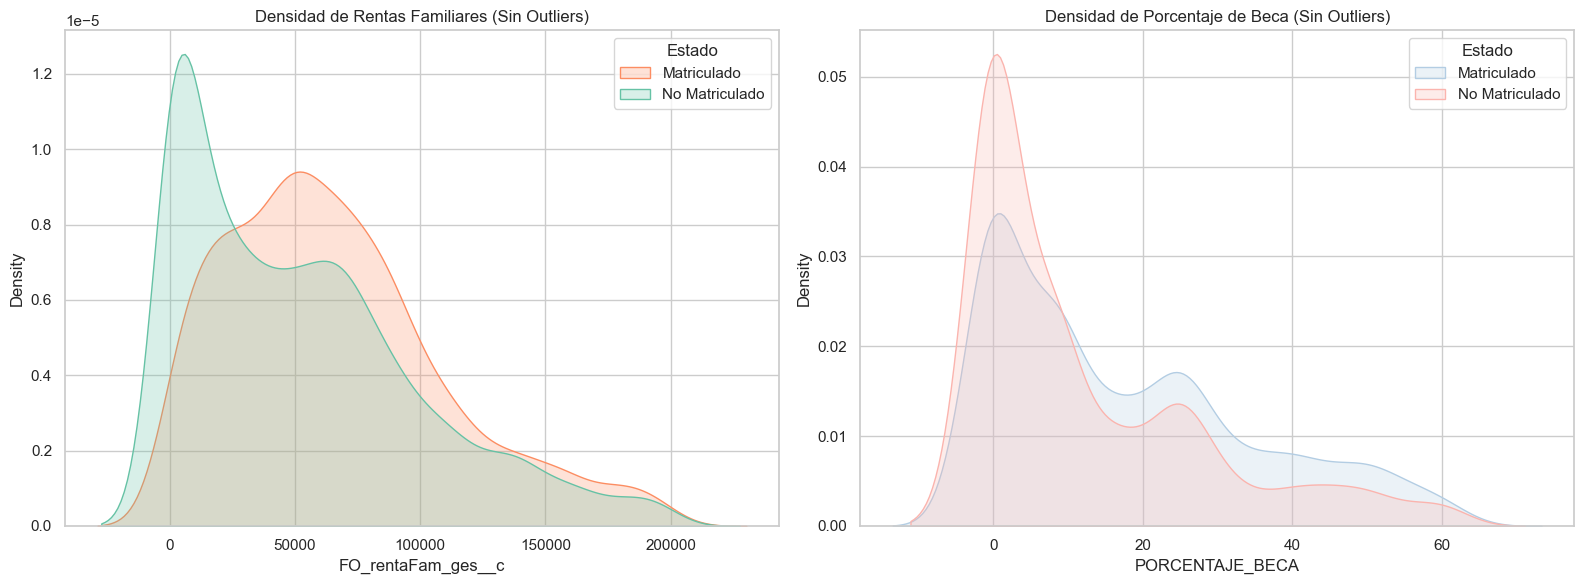

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración estética
sns.set_theme(style="whitegrid")

# --- Preparación de variables y limpieza de outliers ---
datos_analisis['PORCENTAJE_BECA'] = (1 - (datos_analisis['CU_precioAplicado_def__c'] / datos_analisis['CU_precioOrdinario_def__c'])) * 100

def limpiar_outliers_df(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[columna] >= lower) & (df[columna] <= upper)]

# Limpiamos para las gráficas de distribución (eliminando NaNs también)
df_renta_clean = limpiar_outliers_df(datos_analisis.dropna(subset=['FO_rentaFam_ges__c']), 'FO_rentaFam_ges__c')
df_beca_clean = limpiar_outliers_df(datos_analisis.dropna(subset=['PORCENTAJE_BECA']), 'PORCENTAJE_BECA')

# =========================================================
# 1. DISTRIBUCIÓN DE RENTAS Y BECAS (KDE Plots)
# =========================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribución de Rentas
sns.kdeplot(data=df_renta_clean, x='FO_rentaFam_ges__c', hue='target', 
            fill=True, common_norm=False, palette='Set2', ax=axes[0])
axes[0].set_title('Densidad de Rentas Familiares (Sin Outliers)')
axes[0].legend(title='Estado', labels=['Matriculado', 'No Matriculado'])

# Distribución de % de Beca
sns.kdeplot(data=df_beca_clean, x='PORCENTAJE_BECA', hue='target', 
            fill=True, common_norm=False, palette='Pastel1', ax=axes[1])
axes[1].set_title('Densidad de Porcentaje de Beca (Sin Outliers)')
axes[1].legend(title='Estado', labels=['Matriculado', 'No Matriculado'])

plt.tight_layout()
plt.show()


Aquí se puede observar dos cosas:

1. Respecto a la renta familiar, las rentas bajas tienen menor número de matriculados. En cambio, a medida que aumenta la renta familiar, el número de matriculados aumenta, superando al número de no matriculados con rentas similares.

2. Si observamos el porcentaje de beca, en porcentajs de beca pequeños (menos del 15%) hay un mayor número de desmatriculados. En cambio, a medida que aumenta el porcentaje de beca, el número de matriculados es superior al de no matriculados.

Ahora vamos a realizar un análisis de la tasa de matriculación según si se trata de hijos de empleados, de profesores asociados o no cuenta con ninguno de los beneficios:

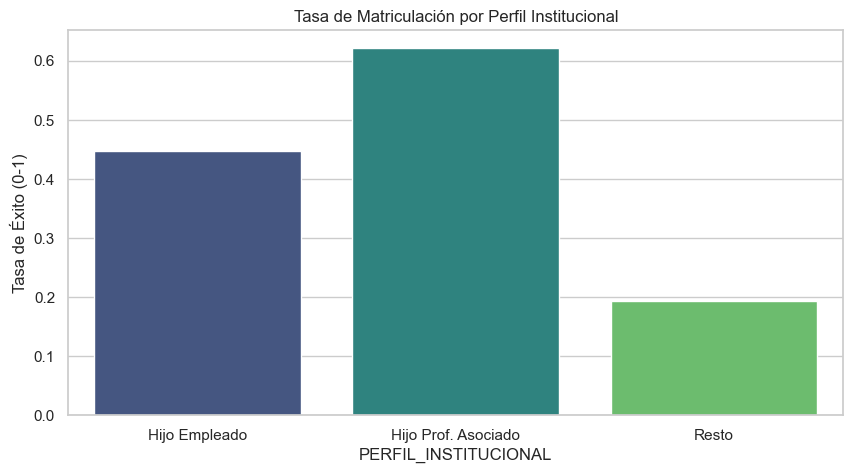

In [11]:
# =========================================================
# 2. HIJOS DE EMPLEADOS Y PROFESORES
# =========================================================
def segmentar_perfil(row):
    if row['CH_HIJO_EMPLEADO__PC'] == 1: return 'Hijo Empleado'
    if row['CH_HIJO_PROFESOR_ASOCIADO__PC'] == 1: return 'Hijo Prof. Asociado'
    return 'Resto'

datos_analisis['PERFIL_INSTITUCIONAL'] = datos_analisis.apply(segmentar_perfil, axis=1)
perfil_stats = datos_analisis.groupby('PERFIL_INSTITUCIONAL')['target'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=perfil_stats, x='PERFIL_INSTITUCIONAL', y='target', 
            palette='viridis', hue='PERFIL_INSTITUCIONAL', legend=False)
plt.title('Tasa de Matriculación por Perfil Institucional')
plt.ylabel('Tasa de Éxito (0-1)')
plt.show()


Aquí se puede observar que la tasa de matriculación es muy superior en aquellos alumnos que cuentan con beneficios. En cambio, dentro de los alumnos con beneficios, la tasa de matriculación es muy superior entre los hijos de los profesores asociados.

Ahora veremos un gráfico con los colegios con mayor tasa de conversión:

TOP 10 COLEGIOS CON MAYOR TASA DE MATRICULACIÓN:


,CENTROENSENANZA,Total_Alumnos,Tasa_Conversion
3902,I.E.S. Reyes Católicos,6,0.833333
6507,Universidad Católica de El Salvador,8,0.750000
5678,St. John XXIII College Preparatory,7,0.714286
6713,Universidad de Montevideo,25,0.680000
6614,Universidad Notre Dame de Haití,6,0.666667
6586,Universidad Latinoamericana de Ciencia y Tecno...,6,0.666667
5688,St. Martin's Academy,9,0.666667
3467,I.E.S. CELSO DIAZ,6,0.666667
6092,UNIVERSIDAD DE GIRONA,9,0.666667
2856,ETSI (Escuela Técnica Superior de Ingeniería ),8,0.625000


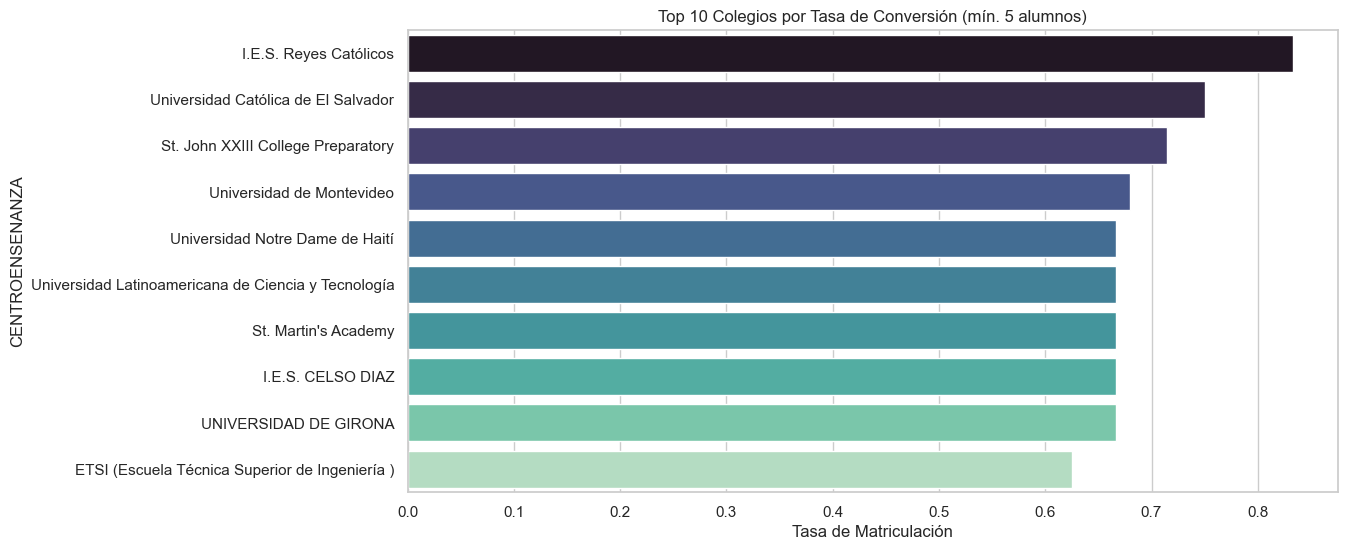

In [12]:
# =========================================================
# 3. COLEGIOS DE ORIGEN
# =========================================================
colegios = datos_analisis.groupby('CENTROENSENANZA')['target'].agg(['count', 'mean']).reset_index()
colegios = colegios[colegios['count'] > 5].sort_values(by='mean', ascending=False)

print("TOP 10 COLEGIOS CON MAYOR TASA DE MATRICULACIÓN:")
display(colegios.head(10).rename(columns={'count': 'Total_Alumnos', 'mean': 'Tasa_Conversion'}))

plt.figure(figsize=(12, 6))
top_10_col = colegios.head(10)
sns.barplot(data=top_10_col, x='mean', y='CENTROENSENANZA', 
            palette='mako', hue='CENTROENSENANZA', legend=False)
plt.title('Top 10 Colegios por Tasa de Conversión (mín. 5 alumnos)')
plt.xlabel('Tasa de Matriculación')
plt.show()

## Análisis de las notas

En este apartado queremos analizar el conjunto de datos para intentar dar respuesta a las siguientes preguntas:

1. ¿Influye los plazos en el porcentaje de matrícula? ¿Hay muchos menos matriculados en diciembre que en marzo o en rolling? ¿Qué notas de admisión tienen cada uno?

2. ¿Hay mucha diferencia en las tasas de matriculados por carrera y plazo en el que se presenta?

3. ¿Qué perfil de alumno se presenta en Diciembre, en Marzo y en Rolling? ¿Qué diferencia hay entre ellos? ¿Cuándo se producen más desmatriculaciones?

4. ¿Qué notas tienen los matriculados por titulación? ¿Qué notas tienen los matriculados por plazo de admisión y título?

En primer lugar, veremos un gráfico con el volumen de oportunidades por plazo de admisión y la tasa de matriculación de cada uno de ellos:

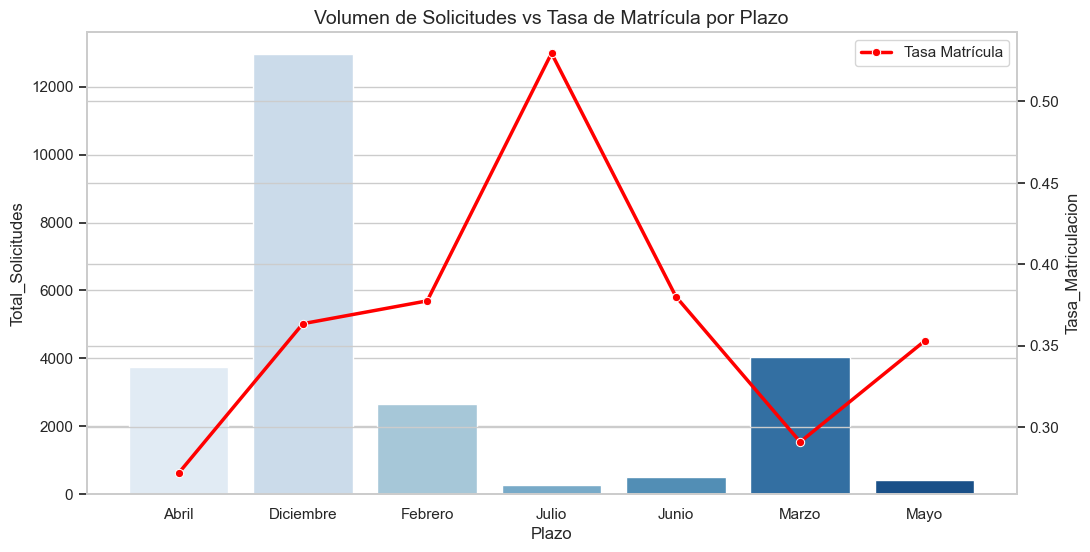

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración inicial
sns.set_theme(style="whitegrid")

# 1. Limpieza de datos previa para evitar errores en el análisis de notas
df_clean = datos_analisis.dropna(subset=['NU_RESULTADO_ADMISION_PUNTOS', 'PL_PLAZO_ADMISION']).copy()

# =========================================================
# 1. ANÁLISIS DE PLAZOS: VOLUMEN, % ÉXITO Y NOTAS
# =========================================================
# Calculamos estadísticas por plazo
plazo_stats = df_clean.groupby('PL_PLAZO_ADMISION').agg({
    'target': ['count', 'mean'],
    'NU_RESULTADO_ADMISION_PUNTOS': 'mean'
}).reset_index()
plazo_stats.columns = ['Plazo', 'Total_Solicitudes', 'Tasa_Matriculacion', 'Nota_Media']

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Barras: Volumen / Línea: Tasa de éxito
sns.barplot(data=plazo_stats, x='Plazo', y='Total_Solicitudes', ax=ax1, palette='Blues', hue='Plazo', legend=False)
sns.lineplot(data=plazo_stats, x='Plazo', y='Tasa_Matriculacion', ax=ax2, color='red', marker='o', linewidth=2.5, label='Tasa Matrícula')

ax1.set_title('Volumen de Solicitudes vs Tasa de Matrícula por Plazo', fontsize=14)
plt.show()



Aquí podemos ver que el plazo con mayor volumen de oportunidades es Diciembre. En cambio, en plazo en el que menos oportunidades hay es Julio, pero presenta la mayor tasa de matriculaciones.

Ahora vamos a realizar un gráfico para revisar la distribución de las notas de admisión por plazo. También veremos la tasa de desmatriculación por plazo:

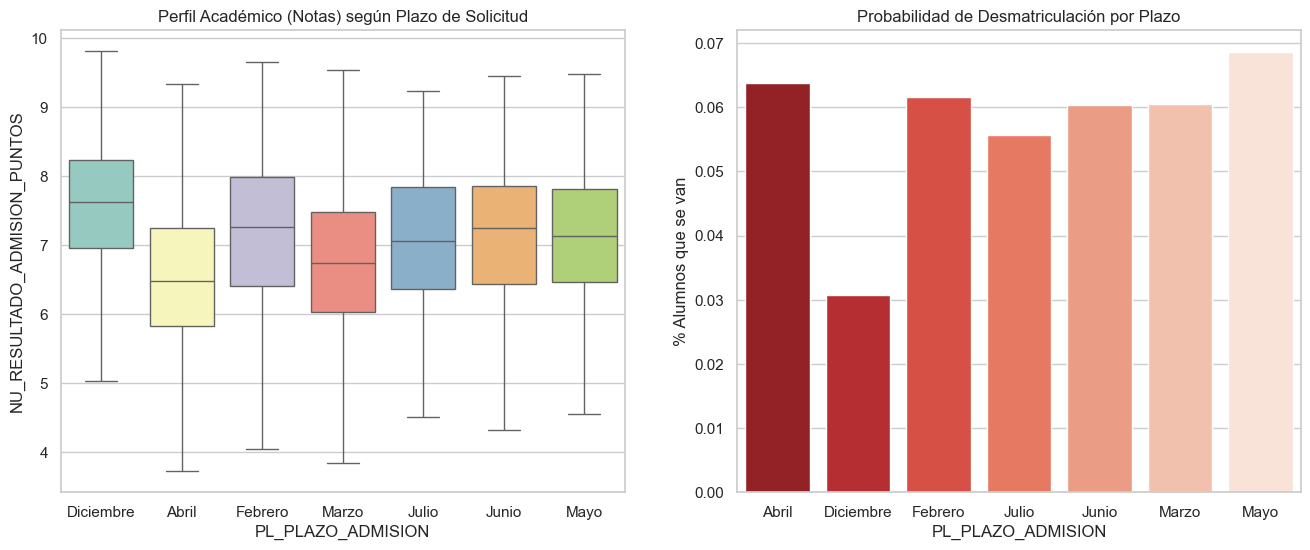

In [14]:
# =========================================================
# 3. PERFIL POR PLAZO Y DESMATRICULACIONES
# =========================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Perfil académico por plazo
sns.boxplot(data=df_clean, x='PL_PLAZO_ADMISION', y='NU_RESULTADO_ADMISION_PUNTOS', 
            ax=axes[0], palette='Set3', hue='PL_PLAZO_ADMISION', legend=False, showfliers=False)
axes[0].set_title('Perfil Académico (Notas) según Plazo de Solicitud')

# Desmatriculaciones por plazo
desmat_stats = df_clean.groupby('PL_PLAZO_ADMISION')['desmatriculado'].mean().reset_index()
sns.barplot(data=desmat_stats, x='PL_PLAZO_ADMISION', y='desmatriculado', 
            ax=axes[1], palette='Reds_r', hue='PL_PLAZO_ADMISION', legend=False)
axes[1].set_title('Probabilidad de Desmatriculación por Plazo')
axes[1].set_ylabel('% Alumnos que se van')

plt.show()

Aquí se pueden observar varios temas:

1. En diciembre se presentan aquellos alumnos con mejores resultados académicos, ya que sus notas son claramente superiores al resto de alumnos que se presentan en otros plazos.

2. La tasa de desmatriculaciones; es decir, el número de desmatriculaciones entre el total de oportunidades es más bajo en diciembre, ya que hay que tener en cuenta que es el plazo de admisión con mayor volumen de oportunidades. En el resto de plazos, las tasas son parecidas, excepto en mayo que es ligeramente superior al resto.

Por último, vamos a ver la tasa de matriculación por titulación y plazo de admisión:

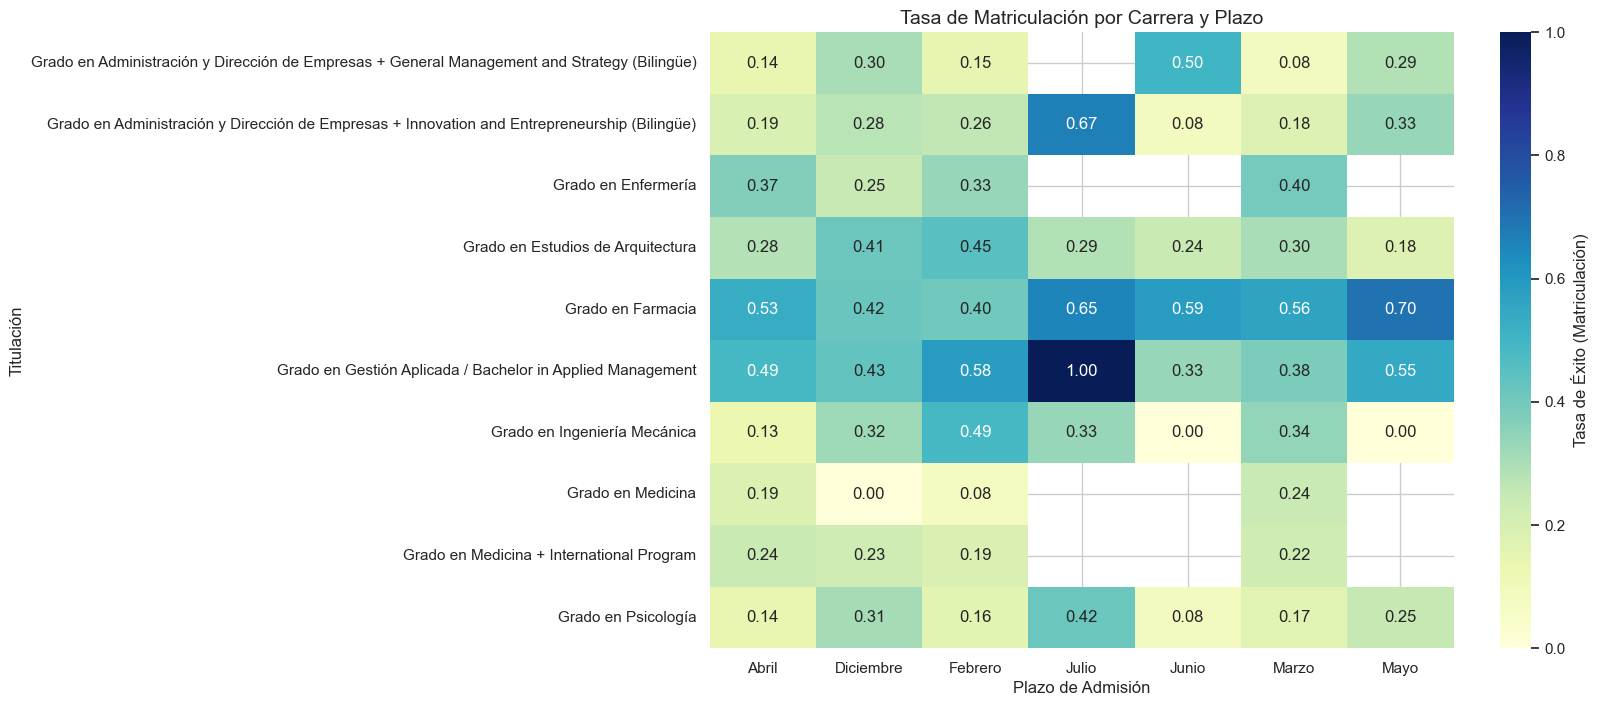

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Limpieza y preparación (Top 10 titulaciones)
df_clean = datos_analisis.dropna(subset=['NU_RESULTADO_ADMISION_PUNTOS', 'PL_PLAZO_ADMISION']).copy()
top_tit = df_clean['TITULACION'].value_counts().head(10).index
df_top = df_clean[df_clean['TITULACION'].isin(top_tit)]

# 2. Creación de la tabla pivote
pivot_tasa = df_top.pivot_table(index='TITULACION', columns='PL_PLAZO_ADMISION', values='target', aggfunc='mean')

# =========================================================
# GRÁFICO CORREGIDO: Mapa de Calor
# =========================================================
plt.figure(figsize=(12, 8))

# Corregido: Usamos cbar_kws para poner la etiqueta a la barra de color
sns.heatmap(pivot_tasa, 
            annot=True, 
            fmt=".2f", 
            cmap="YlGnBu", 
            cbar_kws={'label': 'Tasa de Éxito (Matriculación)'})

plt.title('Tasa de Matriculación por Carrera y Plazo', fontsize=14)
plt.xlabel('Plazo de Admisión')
plt.ylabel('Titulación')
plt.show()



Aquí se puede observar para cada titulación, las distintas tasas de matriculación en función del plazo de admisión. Por ejemplo, en Farmacia son más altas a medida que nos acercamos a junio-julio. En medicina y enfermería, es más alta en marzo y abril que en febrero.

## Análisis de la procedencia de grado o máster

En este apartado vamos a realizar una distincion de los centros de enseñanza dependiendo de si son hacia grado o hacia master. Para ello:

1. Se reutilizará el analisis previo de los centros de enseñanza visto más arriba.

2. Se aplicarán los filtros de grado o master para distribuirlos en estos dos grupos.

3. Se procederá a generar unos graficos para poder ilustrar las conclusiones extraidas.

,CENTROENSENANZA,TIPO_ESTUDIO,Total_Alumnos,Tasa_Conversion
6300,St. Martin's Academy,Máster,6,1.000000
7378,Universidad Católica de El Salvador,Máster,7,0.857143
4298,I.E.S. Reyes Católicos,Grado,6,0.833333
6288,St. John XXIII College Preparatory,Grado,7,0.714286
6739,UNIVERSIDAD CATÓLICA SAN ANTONIO,Máster,7,0.714286
7664,Universidad de Piura - Campus Lima,Máster,25,0.680000
3851,I.E.S. CELSO DIAZ,Grado,6,0.666667
7483,Universidad Latinoamericana de Ciencia y Tecno...,Máster,6,0.666667
6804,UNIVERSIDAD DE GIRONA,Máster,9,0.666667
7647,Universidad de Montevideo,Máster,21,0.666667


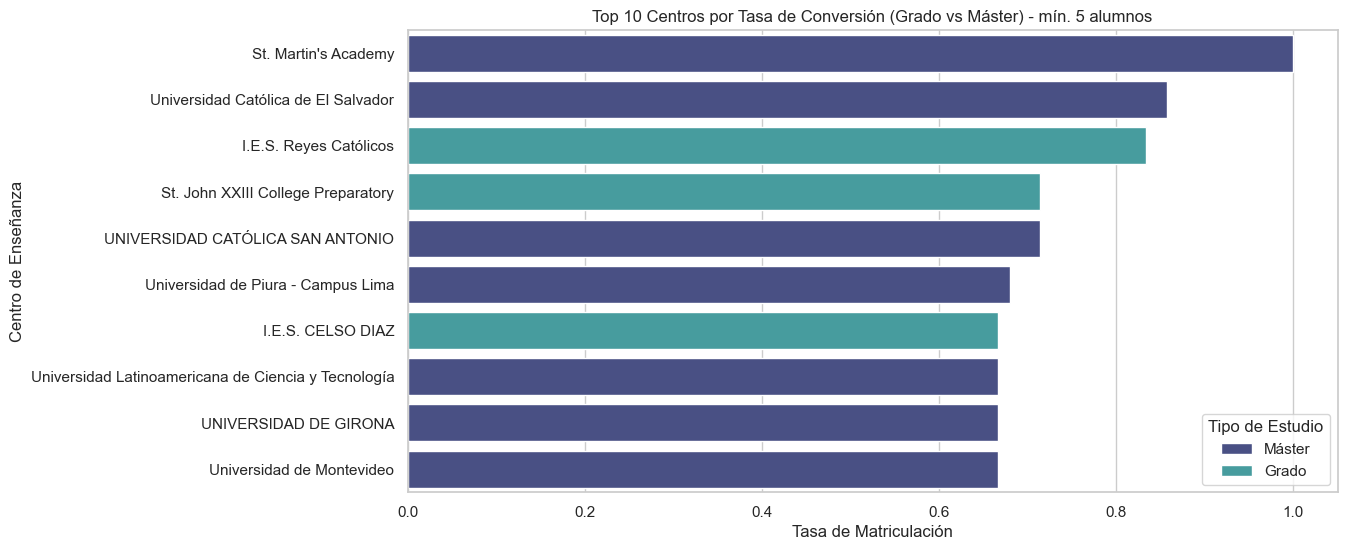


TOP 10 Centros que envían a Grado:


,CENTROENSENANZA,TIPO_ESTUDIO,Total_Alumnos,Tasa_Conversion
4298,I.E.S. Reyes Católicos,Grado,6,0.833333
6288,St. John XXIII College Preparatory,Grado,7,0.714286
3851,I.E.S. CELSO DIAZ,Grado,6,0.666667
4330,I.E.S. SATURNINO MONTOJO,Grado,8,0.625000
4608,Implika Pamplona,Grado,11,0.545455
4990,Jordan High School,Grado,11,0.545455
3340,Escuela de Arte y Superior de Diseño,Grado,11,0.545455
3338,Escuela de Arte Pamplona,Grado,24,0.541667
6006,SAGRADO CORAZON-MUNDAIZ IKASTETXEA,Grado,43,0.534884
1836,C. PEÑAMAYOR,Grado,42,0.523810


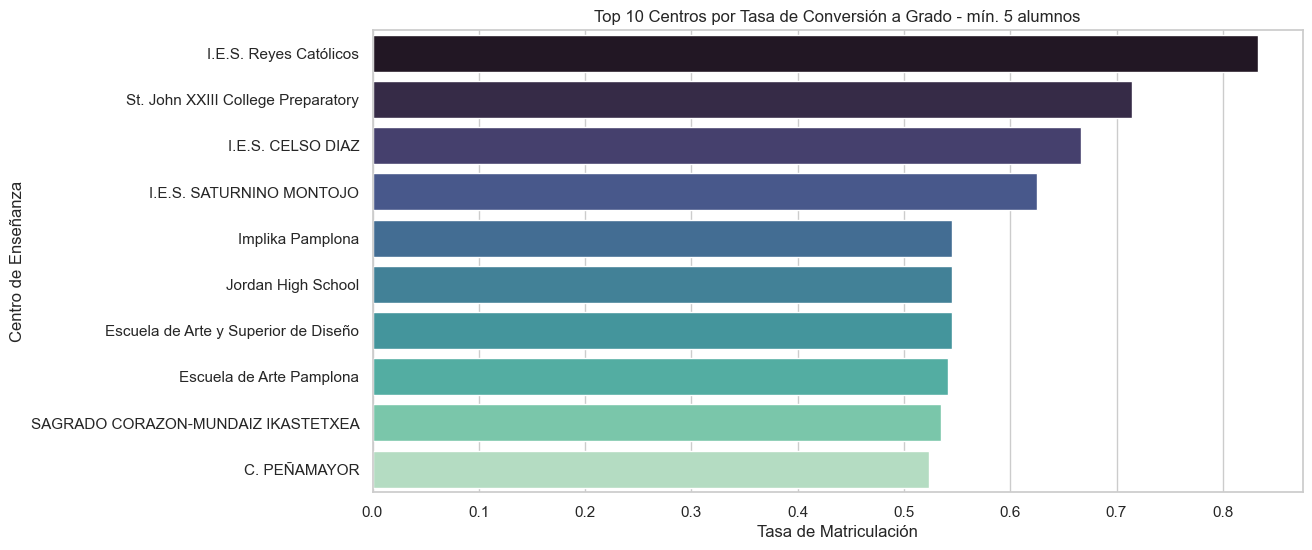


TOP 10 Centros que envían a Máster:


,CENTROENSENANZA,TIPO_ESTUDIO,Total_Alumnos,Tasa_Conversion
6300,St. Martin's Academy,Máster,6,1.000000
7378,Universidad Católica de El Salvador,Máster,7,0.857143
6739,UNIVERSIDAD CATÓLICA SAN ANTONIO,Máster,7,0.714286
7664,Universidad de Piura - Campus Lima,Máster,25,0.680000
6804,UNIVERSIDAD DE GIRONA,Máster,9,0.666667
7647,Universidad de Montevideo,Máster,21,0.666667
6782,UNIVERSIDAD DE CASTILLA LA MANCHA,Máster,6,0.666667
7483,Universidad Latinoamericana de Ciencia y Tecno...,Máster,6,0.666667
7068,UNIVERSIDAD PONTIFICIA DE SALAMANCA,Máster,22,0.636364
7084,UNIVERSIDAD RAMÓN LLULL,Máster,22,0.636364


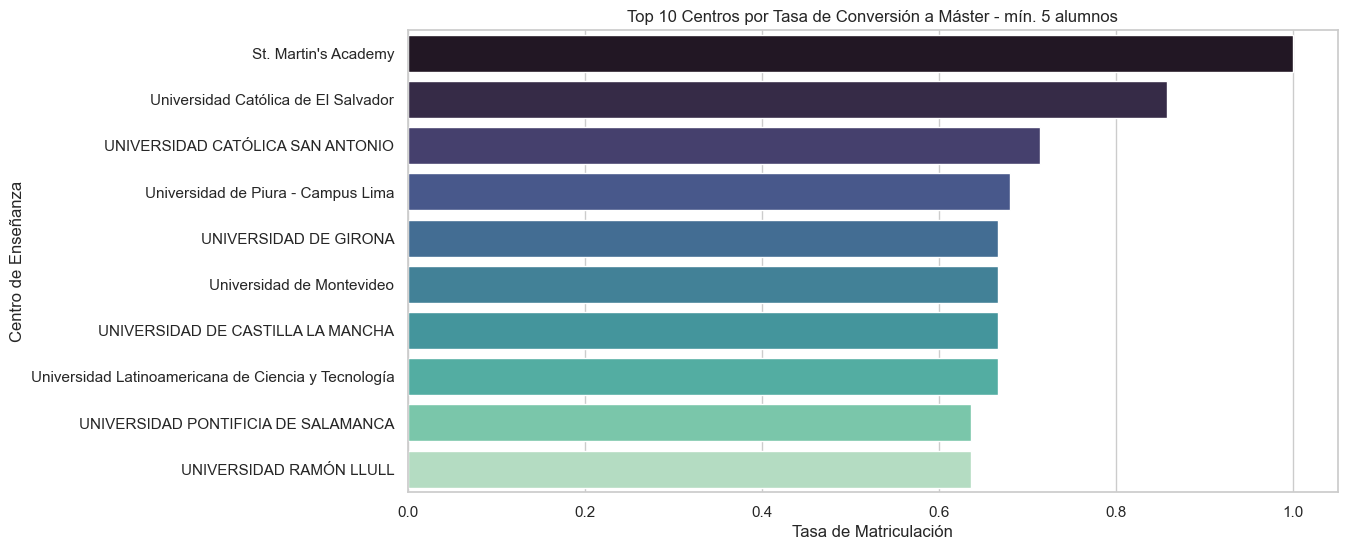

In [16]:
# =========================================================
# COLEGIOS DE ORIGEN - Separado por Grado y Máster (TOP 10)
# =========================================================

# Crear columna simplificada
datos_analisis['TIPO_ESTUDIO'] = datos_analisis['TITULACION'].astype(str).apply(
    lambda x: 'Grado' if 'Grado' in x else 'Máster'
)

# Agrupar por centro y tipo de estudio
colegios = (
    datos_analisis
    .groupby(['CENTROENSENANZA', 'TIPO_ESTUDIO'])['target']
    .agg(['count', 'mean'])
    .reset_index()
)

# Filtrar por mínimo de alumnos
colegios = colegios[colegios['count'] > 5]

# Ordenar por tasa de conversión y quedarnos con los 10 primeros
top_10 = colegios.sort_values(by='mean', ascending=False).head(10)

# Mostrar tabla
display(top_10.rename(columns={'count': 'Total_Alumnos', 'mean': 'Tasa_Conversion'}))

# Gráfica
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_10,
    x='mean',
    y='CENTROENSENANZA',
    hue='TIPO_ESTUDIO',
    palette='mako'
)
plt.title('Top 10 Centros por Tasa de Conversión (Grado vs Máster) - mín. 5 alumnos')
plt.xlabel('Tasa de Matriculación')
plt.ylabel('Centro de Enseñanza')
plt.legend(title='Tipo de Estudio')
plt.show()

# Función para mostrar TOP 10 de un tipo de estudio
def mostrar_top(tipo):
    top_tipo = (
        colegios[colegios['TIPO_ESTUDIO'] == tipo]
        .sort_values(by='mean', ascending=False)
        .head(10)
    )
    
    print(f"\nTOP 10 Centros que envían a {tipo}:")
    display(top_tipo.rename(columns={'count': 'Total_Alumnos', 'mean': 'Tasa_Conversion'}))
    
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=top_tipo,
        x='mean',
        y='CENTROENSENANZA',
        hue='CENTROENSENANZA',
        palette='mako'
    )
    plt.title(f'Top 10 Centros por Tasa de Conversión a {tipo} - mín. 5 alumnos')
    plt.xlabel('Tasa de Matriculación')
    plt.ylabel('Centro de Enseñanza')
    plt.show()

# Mostrar TOP 10 para Grado y Máster
mostrar_top('Grado')
mostrar_top('Máster')


Los graficos creados muestran los 10 centros con mayor tasa de matriculacion, siendo el primero de ellos un conjunto de ambas posibilidades, y los dos siguientes son para ver los grados y los master, respectivamente.

Se pueden observar varias cosas releventes:

- Con respecto al grafico que engloba ambos estudios, podemos ver que, significativamente, hay más instituciones que envian alumnos a máster, que las que envían alumnos a grado, siendo esta diferencia de 7 a 3.

- Viendo la ditribucion de grados, llegamos a la conclusión de que, los centros I.E.S. Reyes Católicos, St. John XXIII College Preparatory, I.E.S. CELSO DIAZ e I.E.S. saturnino nontojo, tienen una tasa de matriculacion bastante mayor que los 6 restantes, los cuales se encuentran prácticamente a la par.

- Con respecto a la distribución de master, a la cabeza se encuentran la St. Martin´s Academy y la Universidad Ctólica de El Salvador,con bastante diferencia, seguidas de la UNIVERSIDAD CATÓLICA SAN ANTONIO, y encontrándose debajo de ésta las 7 restantes con tasas muy cercanas las unas de las otras.

## Análisis de la tasa de matriculación entre nacional e internacional

En este apartado vamos a realizar una distincion de los centros de enseñanza dependiendo de si son nacionales o de un país extranjero. Para ello:

1. Se reutilizará el analisis previo de los centros de enseñanza visto más arriba.

2. Se aplicarán varios filtros:

                - El primero será para diferenciar entre nacional o internacional.

                - Tras este, estará el de las provincias, para ello se cogera tan solo las provincias pertenecientes a España.

                - Por último, se excluira España y obtener todos los demas paises.

3. Se procederá a generar unos graficos para poder ilustrar las conclusiones extraidas.

In [17]:
# =========================================================
# 1. Cuantificar colegios Nacionales vs Internacionales
# =========================================================

# Crear columna de nacionalidad
datos_analisis['NACIONALIDAD'] = datos_analisis['TX_PAIS_CENTROENSENANZA'].apply(
    lambda x: 'Nacional' if x == 'España' else 'Internacional'
)

# Contar colegios por nacionalidad
conteo_nacionalidad = datos_analisis.groupby('NACIONALIDAD')['CENTROENSENANZA'].nunique().reset_index()
conteo_nacionalidad.rename(columns={'CENTROENSENANZA': 'Num_Colegios'}, inplace=True)

# Mostrar tabla
print("Número de colegios por nacionalidad:")
display(conteo_nacionalidad)

# Gráfico
plt.figure(figsize=(6, 6))
sns.barplot(
    data=conteo_nacionalidad,
    x='NACIONALIDAD',
    y='Num_Colegios',
    hue='NACIONALIDAD',
    palette='mako'
)
plt.title('Número de Colegios Nacionales vs Internacionales')
plt.xlabel('Nacionalidad')
plt.ylabel('Número de Colegios')
plt.show()


KeyError: 'TX_PAIS_CENTROENSENANZA'

El grafico obtenido muestra resultados esperados, ya que se aprecia que hay una basta diferencia entre los centros españoles y los centros extranjeros, superando estos últimos por mas del doble a los nacionals.

In [ ]:
# =========================================================
# 2. Nacionales por provincia / Internacionales por país (TOP 15) con tablas
# =========================================================

# Crear columna de nacionalidad
datos_analisis['NACIONALIDAD'] = datos_analisis['TX_PAIS_CENTROENSENANZA__PC'].apply(
    lambda x: 'Nacional' if x == 'España' else 'Internacional'
)

# --- Nacionales por provincia ---
nacionales = (
    datos_analisis[datos_analisis['NACIONALIDAD'] == 'Nacional']
    .groupby('TX_PROVINCIA_CENTROENSENANZA_cuenta')['CENTROENSENANZA']
    .nunique()
    .reset_index()
    .rename(columns={'CENTROENSENANZA': 'Num_Colegios'})
    .sort_values(by='Num_Colegios', ascending=False)
    .head(15)  # TOP 15
)

# Mostrar tabla
print("Top 15 Provincias con más Colegios Nacionales:")
display(nacionales)

# Hue ficticio para mantener degradado y evitar warning
nacionales['hue_dummy'] = nacionales.index

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    data=nacionales,
    x='Num_Colegios',
    y='TX_PROVINCIA_CENTROENSENANZA_cuenta',
    hue='hue_dummy',
    palette='mako',
    legend=False
)
plt.title('Top 15 Provincias con más Colegios Nacionales')
plt.xlabel('Número de Colegios')
plt.ylabel('Provincia')
plt.show()

# --- Internacionales por país ---
internacionales = (
    datos_analisis[datos_analisis['NACIONALIDAD'] == 'Internacional']
    .groupby('TX_PAIS_CENTROENSENANZA__PC')['CENTROENSENANZA']
    .nunique()
    .reset_index()
    .rename(columns={'CENTROENSENANZA': 'Num_Colegios'})
    .sort_values(by='Num_Colegios', ascending=False)
    .head(15)  # TOP 15
)

# Mostrar tabla
print("Top 15 Países con más Colegios Internacionales:")
display(internacionales)

# Hue ficticio para mantener degradado y evitar warning
internacionales['hue_dummy'] = internacionales.index

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    data=internacionales,
    x='Num_Colegios',
    y='TX_PAIS_CENTROENSENANZA__PC',
    hue='hue_dummy',
    palette='mako',
    legend=False
)
plt.title('Top 15 Países con más Colegios Internacionales')
plt.xlabel('Número de Colegios')
plt.ylabel('País')
plt.show()


Con respecto a la segunda parte, la distincion entre provincias españolas y paises extranjeras, podemos sacar varias conclusiones de cada uno de los gráficos:

· Top 15 Provincias con más colegios nacionales:

1. Se puede apreciar que Madrid es la comunidad con más colegios para la Universidad de Navarra, superando por más del doble a la segunda posición, Barcelona.

2. También se puede apreciar que las provincias mas cercanas a la UNAV estan entre las que más colegios tienen

3. Las ultimas provincias de este listado de las 15 con mayor número de colegios apenas llegan a 50 centros.


· Top 15 Países con más Colegios Internacionales:

1. Estados Unidos es de lejos el pais con mayor número de colegios.

2. Se puede apreciar que a excepción de los 6 primeros países, el resto ronda los 100 colegios, unos lo superan por poco, y otros casi llegan a esa cifra.

### Por tasa de matriculación

Ahora vamos a realizar el analisis anterior, pero sustituyen el estudio por numero de colegios, por la tasa de matriculación.

In [18]:
# =========================================================
# Tasa de matriculación por centros (Nacional vs Internacional) - Filtrado correcto
# =========================================================

# Crear columna de nacionalidad
datos_analisis['NACIONALIDAD'] = datos_analisis['TX_PAIS_CENTROENSENANZA__PC'].apply(
    lambda x: 'Nacional' if x == 'España' else 'Internacional'
)

# --- Nacionales por provincia (solo España) ---
nacionales_tasa_centros = (
    datos_analisis[
        (datos_analisis['NACIONALIDAD'] == 'Nacional') &
        (datos_analisis['TX_PAIS_CENTROENSENANZA__PC'] == 'España')  # filtro extra
    ]
    .groupby('TX_PROVINCIA_CENTROENSENANZA_cuenta')['target']
    .agg(['count', 'mean'])
    .reset_index()
    .rename(columns={'count': 'Total_Centros', 'mean': 'Tasa_Conversion'})
    .sort_values(by='Tasa_Conversion', ascending=False)
    .head(15)
)

print("Top 15 Provincias Nacionales por Tasa de Matriculación (por centros) - Solo España:")
display(nacionales_tasa_centros)

# Hue ficticio para mantener degradado y evitar warning
nacionales_tasa_centros['hue_dummy'] = nacionales_tasa_centros.index

plt.figure(figsize=(10, 6))
sns.barplot(
    data=nacionales_tasa_centros,
    x='Tasa_Conversion',
    y='TX_PROVINCIA_CENTROENSENANZA_cuenta',
    hue='hue_dummy',
    palette='mako',
    legend=False
)
plt.title('Top 15 Provincias Nacionales por Tasa de Matriculación (por centros) - Solo España')
plt.xlabel('Tasa de Matriculación')
plt.ylabel('Provincia')
plt.show()

# --- Internacionales por país ---
internacionales_tasa_centros = (
    datos_analisis[datos_analisis['NACIONALIDAD'] == 'Internacional']
    .groupby('TX_PAIS_CENTROENSENANZA__PC')['target']
    .agg(['count', 'mean'])
    .reset_index()
    .rename(columns={'count': 'Total_Centros', 'mean': 'Tasa_Conversion'})
    .sort_values(by='Tasa_Conversion', ascending=False)
    .head(15)
)

print("Top 15 Países Internacionales por Tasa de Matriculación (por centros):")
display(internacionales_tasa_centros)

# Hue ficticio para mantener degradado y evitar warning
internacionales_tasa_centros['hue_dummy'] = internacionales_tasa_centros.index

plt.figure(figsize=(10, 6))
sns.barplot(
    data=internacionales_tasa_centros,
    x='Tasa_Conversion',
    y='TX_PAIS_CENTROENSENANZA__PC',
    hue='hue_dummy',
    palette='mako',
    legend=False
)
plt.title('Top 15 Países Internacionales por Tasa de Matriculación (por centros)')
plt.xlabel('Tasa de Matriculación')
plt.ylabel('País')
plt.show()


KeyError: 'TX_PAIS_CENTROENSENANZA__PC'

· Top 15 Provincias Nacionales por Tasa de Matriculación (por centros) - Solo España:

1. Se puede apreciar bastantes cosas a simple vista, como que Ourense, Logroño y Reus son las provincias con mayor tasa, alcanzando el máximo posible. Y a su vez, doblando por completo al resto de provincias.

2. La provincia por debajo de las tres principales, incluyendo Navarra, no alcanzan el 40% de la tasa, quedándose entre el 25 y 37%.


· Top 15 Países Internacionales por Tasa de Matriculación (por centros):

1. Con respecto a los paises, se aprecian resultados bastante bajos, puesto que ninguno alcanza el 40% de tasa.

2. En la cabeza se encuentra Tanzania, y a diferencia del grafico anterior, Estados Unidos nisiquiera alcanza un pueso en el top.

3. Vemos que varios países se estancan en el 25% de tasa de matriculación.

### Por número de matriculados

Ahora se repite el analisis pero con el número de matriculados, para poder observar cual es la variación con respecto a la tasa de matriculación.

In [ ]:
# =========================================================
# Número de matriculados por centros (Nacional vs Internacional)
# =========================================================

# Crear columna de nacionalidad
datos_analisis['NACIONALIDAD'] = datos_analisis['TX_PAIS_CENTROENSENANZA__PC'].apply(
    lambda x: 'Nacional' if x == 'España' else 'Internacional'
)

# --- Nacionales por provincia (solo España) ---
nacionales_matriculados = (
    datos_analisis[
        (datos_analisis['NACIONALIDAD'] == 'Nacional') &
        (datos_analisis['TX_PAIS_CENTROENSENANZA__PC'] == 'España')
    ]
    .groupby('TX_PROVINCIA_CENTROENSENANZA_cuenta')['target']
    .agg(['count'])  # solo contamos matriculados
    .reset_index()
    .rename(columns={'count': 'Num_Matriculados'})
    .sort_values(by='Num_Matriculados', ascending=False)
    .head(15)
)

print("Top 15 Provincias Nacionales por Número de Matriculados (Solo España):")
display(nacionales_matriculados)

# Hue ficticio para mantener degradado y evitar warning
nacionales_matriculados['hue_dummy'] = nacionales_matriculados.index

plt.figure(figsize=(10, 6))
sns.barplot(
    data=nacionales_matriculados,
    x='Num_Matriculados',
    y='TX_PROVINCIA_CENTROENSENANZA_cuenta',
    hue='hue_dummy',
    palette='mako',
    legend=False
)
plt.title('Top 15 Provincias Nacionales por Número de Matriculados (Solo España)')
plt.xlabel('Número de Matriculados')
plt.ylabel('Provincia')
plt.show()

# --- Internacionales por país ---
internacionales_matriculados = (
    datos_analisis[datos_analisis['NACIONALIDAD'] == 'Internacional']
    .groupby('TX_PAIS_CENTROENSENANZA__PC')['target']
    .agg(['count'])
    .reset_index()
    .rename(columns={'count': 'Num_Matriculados'})
    .sort_values(by='Num_Matriculados', ascending=False)
    .head(15)
)

print("Top 15 Países Internacionales por Número de Matriculados:")
display(internacionales_matriculados)

# Hue ficticio para mantener degradado y evitar warning
internacionales_matriculados['hue_dummy'] = internacionales_matriculados.index

plt.figure(figsize=(10, 6))
sns.barplot(
    data=internacionales_matriculados,
    x='Num_Matriculados',
    y='TX_PAIS_CENTROENSENANZA__PC',
    hue='hue_dummy',
    palette='mako',
    legend=False
)
plt.title('Top 15 Países Internacionales por Número de Matriculados')
plt.xlabel('Número de Matriculados')
plt.ylabel('País')
plt.show()


#### Se observan bastantes diferencias:

· Top 15 Provincias Nacionales por Número de Matriculados (Solo España):

1. Navarra se pone a la caveza por mucho, sobrepasando los 10000 matriculados.

2. Las tres provincias que antes estaban a la cabeza, ahora han desaparecido del top.

3. Excluyendo las 5 primeras provincias, el resto no llegan a los 900 matriculados.

4. Esas 5 provincias, obtienen matriculados que van, desde casi 1500, hasta sobrepasar los 10000.


· Top 15 Países Internacionales por Número de Matriculados:

1. Con respecto a los paises, se aprecian resultados bastante bajos a comparación de las provincias a nivel de España.

2. Por ejemplo, México tiene el mayor numero de matriculados, sindo este numero 4104, en cambio Navarra tiene 11050. Casi triplica el valor.

3. Ahora Estados Unidos alcanza el quinto puesto.

4. Los países más bajos estan con número entre 500 y 600.

### Camparativa de ambas opciones

Estos graficos albergan las mismas conclusiones que los dos apartados anteriores. Pero son simplemente para tener los gráfios juntos para tener un vistazo rápido de las diferencias.

In [ ]:
# =========================================================
# Comparativa lado a lado: Tasa vs Número de Matriculados con tablas
# =========================================================

# --- Provincias Nacionales ---
print("Top 15 Provincias Nacionales por Tasa de Matriculación:")
display(nacionales_tasa.drop(columns=['hue_dummy']))

print("Top 15 Provincias Nacionales por Número de Matriculados:")
display(nacionales_matriculados.drop(columns=['hue_dummy']))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Tasa de matriculación
sns.barplot(
    data=nacionales_tasa,
    x='Tasa_Conversion',
    y='TX_PROVINCIA_CENTROENSENANZA_cuenta',
    hue='hue_dummy',
    palette='mako',
    legend=False,
    ax=axes[0]
)
axes[0].set_title('Top 15 Provincias Nacionales por Tasa de Matriculación')
axes[0].set_xlabel('Tasa de Matriculación')
axes[0].set_ylabel('Provincia')

# Número de matriculados
sns.barplot(
    data=nacionales_matriculados,
    x='Num_Matriculados',
    y='TX_PROVINCIA_CENTROENSENANZA_cuenta',
    hue='hue_dummy',
    palette='mako',
    legend=False,
    ax=axes[1]
)
axes[1].set_title('Top 15 Provincias Nacionales por Número de Matriculados')
axes[1].set_xlabel('Número de Matriculados')
axes[1].set_ylabel('Provincia')

plt.tight_layout()
plt.show()

# --- Países Internacionales ---
print("Top 15 Países Internacionales por Tasa de Matriculación:")
display(internacionales_tasa.drop(columns=['hue_dummy']))

print("Top 15 Países Internacionales por Número de Matriculados:")
display(internacionales_matriculados.drop(columns=['hue_dummy']))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Tasa de matriculación
sns.barplot(
    data=internacionales_tasa,
    x='Tasa_Conversion',
    y='TX_PAIS_CENTROENSENANZA__PC',
    hue='hue_dummy',
    palette='mako',
    legend=False,
    ax=axes[0]
)
axes[0].set_title('Top 15 Países Internacionales por Tasa de Matriculación')
axes[0].set_xlabel('Tasa de Matriculación')
axes[0].set_ylabel('País')

# Número de matriculados
ax = sns.barplot(
    data=internacionales_matriculados,
    x='Num_Matriculados',
    y='TX_PAIS_CENTROENSENANZA__PC',
    hue='hue_dummy',
    palette='mako',
    legend=False,
    ax=axes[1]
)
ax.bar_label(ax.containers[0], fmt='%d')
axes[1].set_title('Top 15 Países Internacionales por Número de Matriculados')
axes[1].set_xlabel('Número de Matriculados')
axes[1].set_ylabel('País')

plt.tight_layout()
plt.show()


# Evolutivo a lo largo de los años de los que constan datos

En este apartado vamos a realizar, siguiendo los pasos anteriores, una evolucion de los datos a lo largo de los años recientes. Para ello:

1. Se reutilizarán los análisis previos.

2. Se aplicarán los filtros de cursos académicos para distribuirlos en estos grupos.

3. Se realizarán y mostrarán los gráficos respectivos para mostrar el recorrido de los datos a lo largo de los años.

## Procedencia de Grado o Master

#### Evolución anual de matriculados: Grado vs Máster

In [19]:
import numpy as np
from scipy.interpolate import make_interp_spline

# =========================================================
# Evolución anual de matriculados: Grado vs Máster
# =========================================================

# Crear columna TIPO_ESTUDIO a partir de los booleanos
datos_analisis['TIPO_ESTUDIO'] = datos_analisis.apply(
    lambda row: 'Grado' if row['CH_GRADO__PC'] else ('Máster' if row['CH_MASTER__PC'] else 'Otro'),
    axis=1
)

# Agrupar por curso y tipo de estudio
evolutivo_grado_master = (
    datos_analisis[datos_analisis['TIPO_ESTUDIO'].isin(['Grado', 'Máster'])]
    .groupby(['PL_CURSO_ACADEMICO', 'TIPO_ESTUDIO'])['target']
    .sum()
    .reset_index()
    .rename(columns={'target': 'Num_Matriculados'})
    .sort_values(by='PL_CURSO_ACADEMICO')
)

# 🔹 Filtrar para omitir el curso 2026/2027
evolutivo_grado_master = evolutivo_grado_master[evolutivo_grado_master['PL_CURSO_ACADEMICO'] != '2026/2027']

# Mostrar tabla
print("Evolución anual de matriculados (Grado vs Máster):")
display(evolutivo_grado_master)

# Gráfico con curvas suaves
plt.figure(figsize=(10, 6))
for tipo in evolutivo_grado_master['TIPO_ESTUDIO'].unique():
    df_tipo = evolutivo_grado_master[evolutivo_grado_master['TIPO_ESTUDIO'] == tipo]
    x = np.arange(len(df_tipo))
    y = df_tipo['Num_Matriculados'].values
    
    # Interpolación cúbica
    x_new = np.linspace(x.min(), x.max(), 300)
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_new)
    
    plt.plot(np.linspace(0, len(df_tipo)-1, 300), y_smooth, label=tipo)
    plt.scatter(x, y)  # puntos originales

plt.xticks(np.arange(len(df_tipo)), df_tipo['PL_CURSO_ACADEMICO'])
plt.title('Evolución anual de matriculados: Grado vs Máster')
plt.xlabel('Curso Académico')
plt.ylabel('Número de Matriculados')
plt.grid(True)
plt.legend()
plt.show()


KeyError: 'CH_GRADO__PC'

Aquí se ha mostrado un vistazo rápido de la evolución anual de matriculados: Grado vs Máster. Y se pueden apreciar varias observaciones:

1. Dominio del Grado en volumen de matriculados.
    - En todos los cursos desde 2022/2023 hasta 2025/2026, el número de matriculados en Grado es significativamente mayor que en Máster.
    - El Grado se mantiene en torno a los 2.700 - 2.900 matriculados por año, mientras que el Máster oscila entre 700 y 900 matriculados.

2. Tendencia estable con ligera subida.
    - Grado: ligera subida desde 2023/2024 hasta alcanzar un pico en 2025/2026 (~2.900 matriculados).
    - Máster: crecimiento más suave, pasando de ~700 en 2022/2023 a ~900 en 2025/2026.

3. Caída abrupta en 2026/2027.
    - Tanto Grado como Máster muestran 0 matriculados en 2026/2027. Esto tiene sentido puesto que se trata del año venidero, por lo que es logico que aún no haya datos cargados o directamente, disponibles.

4. Relación constante entre Grado y Máster
    - La proporción de matriculados de Grado frente a Máster se mantiene relativamente estable, siendo esta de 3:1 aproximadamente. Durante los años con datos completos.

#### Evolutivo: TOP 10 global por numero de matriculados (Grado y Máster)

In [ ]:
import numpy as np
from scipy.interpolate import make_interp_spline
import pandas as pd
import matplotlib.pyplot as plt

# Crear columna simplificada de tipo de estudio
datos_analisis['TIPO_ESTUDIO'] = datos_analisis['TITULACION'].astype(str).apply(
    lambda x: 'Grado' if 'Grado' in x else 'Máster'
)

# Agrupar por curso, centro y tipo de estudio usando solo número de alumnos
evolutivo_centros = (
    datos_analisis
    .groupby(['PL_CURSO_ACADEMICO', 'CENTROENSENANZA', 'TIPO_ESTUDIO'])['target']
    .agg(['count'])
    .reset_index()
    .rename(columns={'count': 'Total_Alumnos'})
)

# Filtrar por mínimo de alumnos
evolutivo_centros = evolutivo_centros[evolutivo_centros['Total_Alumnos'] > 5]

# Quitar solo el curso 2026/2027
evolutivo_centros = evolutivo_centros[evolutivo_centros['PL_CURSO_ACADEMICO'] != '2026/2027']

# Lista completa de cursos que quieres mostrar
cursos_completos = sorted(evolutivo_centros['PL_CURSO_ACADEMICO'].unique())

def mostrar_top_global(tipo):
    # Calcular TOP 10 global por número de alumnos
    top10_global = (
        evolutivo_centros[evolutivo_centros['TIPO_ESTUDIO'] == tipo]
        .groupby('CENTROENSENANZA')['Total_Alumnos']
        .sum()
        .reset_index()
        .sort_values(by='Total_Alumnos', ascending=False)
        .head(10)['CENTROENSENANZA']
    )

    # Filtrar solo esos centros
    top10_data = evolutivo_centros[
        (evolutivo_centros['TIPO_ESTUDIO'] == tipo) &
        (evolutivo_centros['CENTROENSENANZA'].isin(top10_global))
    ]

    # 🔹 Rellenar años faltantes con NaN
    centros_unicos = top10_data['CENTROENSENANZA'].unique()
    df_completo = []
    for centro in centros_unicos:
        df_centro = top10_data[top10_data['CENTROENSENANZA'] == centro]
        df_centro = df_centro.set_index('PL_CURSO_ACADEMICO').reindex(cursos_completos).reset_index()
        df_centro['CENTROENSENANZA'] = centro
        df_centro['TIPO_ESTUDIO'] = tipo
        df_completo.append(df_centro)
    top10_data = pd.concat(df_completo, ignore_index=True)

    # 📊 Mantener la tabla igual
    print(f"\nTOP 10 Centros globales por Número de Matriculados en {tipo}:")
    display(
        top10_data.groupby('CENTROENSENANZA')['Total_Alumnos']
        .sum()
        .reset_index()
        .sort_values(by='Total_Alumnos', ascending=False)
    )

    # 🎯 Gráfico 1: de 150 a 800
    plt.figure(figsize=(12, 6))
    for centro in top10_data['CENTROENSENANZA'].unique():
        df_centro = top10_data[top10_data['CENTROENSENANZA'] == centro]
        x_numeric = np.arange(len(df_centro))
        y = df_centro['Total_Alumnos'].values
        mask = ~np.isnan(y)
        if mask.sum() > 3:
            x_new = np.linspace(x_numeric.min(), x_numeric.max(), 300)
            spline = make_interp_spline(x_numeric[mask], y[mask], k=3)
            y_smooth = spline(x_new)
            plt.plot(x_new, y_smooth, label=centro)
        else:
            plt.plot(x_numeric, y, label=centro)
        plt.scatter(x_numeric, y)
    plt.xticks(np.arange(len(cursos_completos)), cursos_completos)
    plt.title(f'Evolución del Número de Matriculados - {tipo} (150 a 800)')
    plt.xlabel('Curso Académico')
    plt.ylabel('Número de Matriculados')
    plt.ylim(150, 800)
    plt.yticks(np.arange(150, 801, 50))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

    # 🎯 Gráfico 2: de 0 a 120
    plt.figure(figsize=(12, 6))
    for centro in top10_data['CENTROENSENANZA'].unique():
        df_centro = top10_data[top10_data['CENTROENSENANZA'] == centro]
        x_numeric = np.arange(len(df_centro))
        y = df_centro['Total_Alumnos'].values
        mask = ~np.isnan(y)
        if mask.sum() > 3:
            x_new = np.linspace(x_numeric.min(), x_numeric.max(), 300)
            spline = make_interp_spline(x_numeric[mask], y[mask], k=3)
            y_smooth = spline(x_new)
            plt.plot(x_new, y_smooth, label=centro)
        else:
            plt.plot(x_numeric, y, label=centro)
        plt.scatter(x_numeric, y)
    plt.xticks(np.arange(len(cursos_completos)), cursos_completos)
    plt.title(f'Evolución del Número de Matriculados - {tipo} (0 a 120)')
    plt.xlabel('Curso Académico')
    plt.ylabel('Número de Matriculados')
    plt.ylim(0, 120)
    plt.yticks(np.arange(0, 121, 10))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Mostrar para Grado y Máster
mostrar_top_global('Grado')
mostrar_top_global('Máster')


Conclusiones de Grado:

1. Altas tasas iniciales(2022/2023): Prácticamente todos los centros del TOP parten con tasas de conversión superiores al 0.5, destacando casos como el C. MONTECASTELO, el C. PEÑAMAYOR, o el I.E.S. IBAIALDE.

2. Descensos pronunciados en algunos centros: Centros como el C. MONTECALPE o el I.E.S. MARQUÉS DE VILLENA presentan caidas en picado desde el curso 2023/2024 en adelante.

3. Estabilidad relativa en otros:
    - El I.E.S IBAIALDE o el C.PEÑAMAYOR presentante una continuidad relativamente estable a lo largo de los años.
    - Centros como la Escuela de Arte Pamplona, NTRA. SRA. DE AZITAIN-LA SALLE o San Ignacio de Loyola School presentan una estabilidad referente a un único año.

4. Tendencia general: El conjunto del TOP 10 presenta una ligera tendencia descendente en la tasa de conversión hacia 2025/2026, lo que podría indicar una menor captación relativa en los últimos años.


Concluiones de Máster:

1. Crecimiento destacado en un centro:
    - Universidad Pontificia de Salamanca muestra una tendencia claramente ascendente, pasando de una tasa de conversión cercana a 0.65 en 2022/2023 a aproximadamente 0.85 en 2025/2026, situándose como Nº 2 en liderazgo al final del periodo.
    - Sin embargo, es el único donde se aprecia esta característica.

2. Descensos pronunciados:
    - UNIVERSIDAD RAMÓN LLULL y Universidad de Piura – Campus Lima experimentan caídas muy marcadas, especialmente esta última, que pasa de ser una de las más altas (0.8) en 2023/2024 a la más baja (0.5) en 2025/2026.
    - UNIVERSIDAD CARDENAL HERRERA CEU también muestra una tendencia descendente, aunque menos abrupta.

3. Tendencia general del TOP:
    - El conjunto presenta una media de tasas de conversión alta (todas por encima de 0.5), pero con una clara divergencia: algunos centros mejoran de forma sostenida, mientras que otros pierden capacidad de conversión de manera notable.
    - La estabilidad de varios centros sugiere que la captación de estudiantes de Máster en estos casos es menos sensible a cambios externos, mientras que las caídas abruptas podrían estar relacionadas con factores internos o coyunturales.

4. Comparativa con los Grados:
    - Ambos gráficos muestran descensos en su mayoría a excepcion de un puñado de centros.
    - La principal diferencia en estas caidas es, que en los master son claramente más ligeras, en contraparte a la de los grados, que son preocupantemente más abruptas.

# Evolucion de Nacional(Provincias españolas) vs Internacional(paises extranjeros)

### Por Número de matriculados

#### Evolutivo: Nacional vs Internacional

In [ ]:
import numpy as np
from scipy.interpolate import make_interp_spline

# =========================================================
# Evolutivo: Número de matriculados Nacional vs Internacional (curvado y sin 2026/2027)
# =========================================================

# 1. Crear columna de nacionalidad
datos_analisis['NACIONALIDAD'] = datos_analisis['TX_PAIS_CENTROENSENANZA__PC'].apply(
    lambda x: 'Nacional' if x == 'España' else 'Internacional'
)

# 2. Agrupar por curso y nacionalidad
evolutivo_nac_int = (
    datos_analisis
    .groupby(['PL_CURSO_ACADEMICO', 'NACIONALIDAD'])['target']
    .sum()  # número total de matriculados
    .reset_index()
    .rename(columns={'target': 'Num_Matriculados'})
    .sort_values(by='PL_CURSO_ACADEMICO')
)

# 🔹 3. Omitir el curso 2026/2027
evolutivo_nac_int = evolutivo_nac_int[evolutivo_nac_int['PL_CURSO_ACADEMICO'] != '2026/2027']

# 4. Mostrar tabla
print("Evolución anual del número de matriculados (Nacional vs Internacional):")
display(evolutivo_nac_int)

# 5. Gráfico con curvas suaves
plt.figure(figsize=(10, 6))
for nacionalidad in evolutivo_nac_int['NACIONALIDAD'].unique():
    df_nat = evolutivo_nac_int[evolutivo_nac_int['NACIONALIDAD'] == nacionalidad]
    
    # Convertir cursos a índices numéricos para suavizado
    x_numeric = np.arange(len(df_nat))
    y = df_nat['Num_Matriculados'].values
    
    if len(df_nat) > 3:  # mínimo para spline cúbico
        x_new = np.linspace(x_numeric.min(), x_numeric.max(), 300)
        spline = make_interp_spline(x_numeric, y, k=3)
        y_smooth = spline(x_new)
        plt.plot(x_new, y_smooth, label=nacionalidad)
    else:
        plt.plot(x_numeric, y, label=nacionalidad)
    
    plt.scatter(x_numeric, y)  # puntos originales

# Etiquetas originales en el eje X
plt.xticks(np.arange(len(df_nat)), df_nat['PL_CURSO_ACADEMICO'])
plt.title('Evolución del Número de Matriculados - Nacional vs Internacional')
plt.xlabel('Curso Académico')
plt.ylabel('Número de Matriculados')
plt.grid(True)
plt.legend()
plt.show()


1. Tasas iniciales distintas:
    - En 2022/2023, la tasa de matriculación nacional(0.33) fue más del doble que la internacional(0.14). Esto indica que, de media, los centros españoles atraen a más estudiantes que los extranjeros.

2. Tendencia positiva hasta 2025/2026:
    - En el marco Nacional: Sube del ~0.33 al ~0.35, con un crecimiento suave y sostenido.
    - En el marco Internacional: También crece, aunque más lentamente, pasando de ~0.14 a ~0.15.

3. Brecha constante:
    - La diferencia entre nacional e internacional se mantiene estable en torno a 0.18-0.20 puntos durante los años del registro.

4. Caída abrupta en 2026/2027:
    - Ambos valores caen a 0.0, esto vuelve a tener sentido debido al caso anterior: Se trata del año venidero, por lo que es logico que aún no haya datos cargados o directamente, disponibles. Por lo que queda entonces demostrado, no es una tendencia real.

#### Evolutivo: Número de matriculados por centros - Provincias (España) y Países (Internacionales)

Con respecto a las Provincias(Marco Nacional):

1. Un territorio claramente líder:
    - Navarra se mantiene lider a lo largo de los años, contando con mas de 900 alumnos matriculados.

2. Rango constante para el resto de provincias:
    - El resto de provincias se mantienen en rangos fijos, nunca alcanzando los 150 alumnos.
    - Madrid y Gipuzkoa/Gipúzcoa superan este número, colocandose entre los 200 y 400 alumnos, pero en progresiones constantes.


Con respecto al marco Internacional:

1. País lider:
    - México se mantiene líder constante, siendo el único que se acerca a los 160 en su mayor pico.

2. Franjas claras:
    - Vemos que hay tres rangos establecidos:
    - El primero estaría compuesto únicamente por México, como se menciona en el punto anterior.
    - El del medio estaría oupado por Perú, Estados Unidos, Ecuador y Columbia, ocupando un rango constante entre los casi 60, y los 110 alumnos.
    - El último rango lo ocupan Guatemala, Costa Rica, Honduras, Panamá y Filipinas, siendo incapaces de alcanzar los 40 alumnos a lo largo de la evolución.

3. Comparativa:
    - Como se pudo apreciar en el gráfico general, y ahora se mantiene en este desglose, el marco nacional atrae una cantidad considerablemente mayor en proporcion con los alumnos atraidos en lo internacional.

In [ ]:
import numpy as np
from scipy.interpolate import make_interp_spline

# Mostrar la tabla antes de los gráficos
print("TOP 10 Provincias por número total de matriculados (España):")
display(
    evolutivo_provincias_num_top10.groupby('TX_PROVINCIA_CENTROENSENANZA_cuenta')['Num_Matriculados']
    .sum()
    .reset_index()
    .sort_values(by='Num_Matriculados', ascending=False)
)

# Lista de cursos para asegurar que todos aparecen en el eje X
cursos_completos = sorted(evolutivo_provincias_num_top10['PL_CURSO_ACADEMICO'].unique())

fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Función para dibujar curvas suaves
def plot_curved(ax, df, rango_y=None, ticks_y=None, titulo=""):
    for provincia in df['TX_PROVINCIA_CENTROENSENANZA_cuenta'].unique():
        df_prov = df[df['TX_PROVINCIA_CENTROENSENANZA_cuenta'] == provincia].sort_values('PL_CURSO_ACADEMICO')
        x_numeric = np.arange(len(df_prov))
        y = df_prov['Num_Matriculados'].values
        
        if len(df_prov) > 3:
            x_new = np.linspace(x_numeric.min(), x_numeric.max(), 300)
            spline = make_interp_spline(x_numeric, y, k=3)
            y_smooth = spline(x_new)
            ax.plot(x_new, y_smooth, label=provincia)
        else:
            ax.plot(x_numeric, y, label=provincia)
        
        ax.scatter(x_numeric, y)
    
    ax.set_xticks(np.arange(len(cursos_completos)))
    ax.set_xticklabels(cursos_completos)
    if rango_y:
        ax.set_ylim(rango_y)
    if ticks_y is not None:
        ax.set_yticks(np.arange(rango_y[0], rango_y[1] + ticks_y, ticks_y))
    ax.set_title(titulo)
    ax.set_ylabel('Número de Matriculados')
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# --- 1. Franja 800 a 1200 ---
plot_curved(
    axes[0],
    evolutivo_provincias_num_top10,
    rango_y=(800, 1200),
    titulo='Evolución del Número de Matriculados (800 a 1200)'
)

# --- 2. Franja 100 a 600 con saltos de 100 ---
plot_curved(
    axes[1],
    evolutivo_provincias_num_top10,
    rango_y=(100, 600),
    ticks_y=100,
    titulo='Evolución del Número de Matriculados (100 a 600)'
)

# --- 3. Franja 0 a 100 con saltos de 10 ---
plot_curved(
    axes[2],
    evolutivo_provincias_num_top10,
    rango_y=(0, 100),
    ticks_y=10,
    titulo='Evolución del Número de Matriculados (0 a 100)'
)

axes[2].set_xlabel('Curso Académico')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.interpolate import make_interp_spline

# Mostrar la tabla antes de los gráficos
print("TOP 10 Países por número total de matriculados (Internacionales):")
display(
    evolutivo_paises_num_top10.groupby('TX_PAIS_CENTROENSENANZA__PC')['Num_Matriculados']
    .sum()
    .reset_index()
    .sort_values(by='Num_Matriculados', ascending=False)
)

# Lista de cursos para asegurar que todos aparecen en el eje X
cursos_completos = sorted(evolutivo_paises_num_top10['PL_CURSO_ACADEMICO'].unique())

# Función para dibujar curvas suaves
def plot_curved(ax, df, rango_y=None, ticks_y=None, titulo=""):
    for pais in df['TX_PAIS_CENTROENSENANZA__PC'].unique():
        df_pais = df[df['TX_PAIS_CENTROENSENANZA__PC'] == pais].sort_values('PL_CURSO_ACADEMICO')
        x_numeric = np.arange(len(df_pais))
        y = df_pais['Num_Matriculados'].values
        
        if len(df_pais) > 3:
            x_new = np.linspace(x_numeric.min(), x_numeric.max(), 300)
            spline = make_interp_spline(x_numeric, y, k=3)
            y_smooth = spline(x_new)
            ax.plot(x_new, y_smooth, label=pais)
        else:
            ax.plot(x_numeric, y, label=pais)
        
        ax.scatter(x_numeric, y)
    
    ax.set_xticks(np.arange(len(cursos_completos)))
    ax.set_xticklabels(cursos_completos)
    if rango_y:
        ax.set_ylim(rango_y)
    if ticks_y is not None:
        ax.set_yticks(np.arange(rango_y[0], rango_y[1] + ticks_y, ticks_y))
    ax.set_title(titulo)
    ax.set_ylabel('Número de Matriculados')
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Crear figura con 2 subgráficos
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- 1. Franja 50 a 160 con saltos de 10 ---
plot_curved(
    axes[0],
    evolutivo_paises_num_top10,
    rango_y=(50, 160),
    ticks_y=10,
    titulo='Evolución del Número de Matriculados (50 a 160)'
)

# --- 2. Franja 0 a 40 con saltos de 10 ---
plot_curved(
    axes[1],
    evolutivo_paises_num_top10,
    rango_y=(0, 40),
    ticks_y=10,
    titulo='Evolución del Número de Matriculados (0 a 40)'
)

axes[1].set_xlabel('Curso Académico')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import seaborn as sns

# Mostrar la tabla antes de los gráficos
print("TOP 10 Países por número total de matriculados (Internacionales):")
display(
    evolutivo_paises_num_top10.groupby('TX_PAIS_CENTROENSENANZA__PC')['Num_Matriculados']
    .sum()
    .reset_index()
    .sort_values(by='Num_Matriculados', ascending=False)
)

# Lista de cursos para asegurar que todos aparecen en el eje X
cursos_completos = sorted(evolutivo_paises_num_top10['PL_CURSO_ACADEMICO'].unique())

# Función para dibujar curvas suaves
def plot_curved(ax, df, rango_y=None, ticks_y=None, titulo=""):
    for pais in df['TX_PAIS_CENTROENSENANZA__PC'].unique():
        df_pais = df[df['TX_PAIS_CENTROENSENANZA__PC'] == pais].sort_values('PL_CURSO_ACADEMICO')
        x_numeric = np.arange(len(df_pais))
        y = df_pais['Num_Matriculados'].values
        
        if len(df_pais) > 3:
            x_new = np.linspace(x_numeric.min(), x_numeric.max(), 300)
            spline = make_interp_spline(x_numeric, y, k=3)
            y_smooth = spline(x_new)
            ax.plot(x_new, y_smooth, label=pais)
        else:
            ax.plot(x_numeric, y, label=pais)
        
        ax.scatter(x_numeric, y)
    
    ax.set_xticks(np.arange(len(cursos_completos)))
    ax.set_xticklabels(cursos_completos)
    if rango_y:
        ax.set_ylim(rango_y)
    if ticks_y is not None:
        ax.set_yticks(np.arange(rango_y[0], rango_y[1] + ticks_y, ticks_y))
    ax.set_title(titulo)
    ax.set_ylabel('Número de Matriculados')
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Crear figura con 2 subgráficos
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- 1. Franja 50 a 160 con saltos de 10 ---
plot_curved(
    axes[0],
    evolutivo_paises_num_top10,
    rango_y=(50, 160),
    ticks_y=10,
    titulo='Evolución del Número de Matriculados (50 a 160)'
)

# --- 2. Franja 0 a 40 con saltos de 5 ---
plot_curved(
    axes[1],
    evolutivo_paises_num_top10,
    rango_y=(0, 40),
    ticks_y=5,
    titulo='Evolución del Número de Matriculados (0 a 40)'
)

axes[1].set_xlabel('Curso Académico')

plt.tight_layout()
plt.show()


### Por tasa de matriculacion en funcion del numero de matriculados visto anteriormente

Araba/Álava, Barcelona, Bizkaia/Vizcaya, Gipuzkoa/Guipúzcoa, La Rioja, Madrid, Navarra, Sevilla, Valencia, Zaragoza

Colombia, Costa Rica, Ecuador, Estados Unidos, Filipinas, Guatemala, Honduras, México, Panamá, Perú

In [ ]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

# 1⃣ Lista de provincias nacionales TOP
provincias_top_num = [
    "Araba/Alava", "Barcelona", "Bizkaia/Vizcaya", "Gipuzkoa/Guipúzcoa",
    "La Rioja", "Madrid", "Navarra", "Sevilla", "Valencia", "Zaragoza"
]

# 2⃣ Filtrar datos para esas provincias y quitar 2026/2027
df_provincias = datos_analisis[
    (datos_analisis['TX_PROVINCIA_CENTROENSENANZA_cuenta'].isin(provincias_top_num)) &
    (datos_analisis['PL_CURSO_ACADEMICO'] != '2026/2027')
]

# 3⃣ Calcular tasa de conversión total (global) para cada provincia
tasa_conversion_total = (
    df_provincias.groupby('TX_PROVINCIA_CENTROENSENANZA_cuenta')['target']
    .mean()  # tasa de conversión global
    .reset_index()
    .rename(columns={'target': 'Tasa_Conversion_Total'})
    .sort_values(by='Tasa_Conversion_Total', ascending=False)
)

# Mostrar tabla
print("Tasa de conversión TOTAL para provincias TOP por número de matriculados:")
display(tasa_conversion_total)

# 4⃣ Calcular tasa de conversión por año para el gráfico
tasa_conversion_por_ano = (
    df_provincias.groupby(['PL_CURSO_ACADEMICO', 'TX_PROVINCIA_CENTROENSENANZA_cuenta'])['target']
    .mean()
    .reset_index()
    .rename(columns={'target': 'Tasa_Conversion'})
    .sort_values(by='PL_CURSO_ACADEMICO')
)

# 5⃣ Graficar con líneas curvadas
cursos_completos = sorted(tasa_conversion_por_ano['PL_CURSO_ACADEMICO'].unique())

plt.figure(figsize=(12, 6))
for prov in tasa_conversion_por_ano['TX_PROVINCIA_CENTROENSENANZA_cuenta'].unique():
    df_prov = tasa_conversion_por_ano[tasa_conversion_por_ano['TX_PROVINCIA_CENTROENSENANZA_cuenta'] == prov].sort_values('PL_CURSO_ACADEMICO')
    x_numeric = np.arange(len(df_prov))
    y = df_prov['Tasa_Conversion'].values
    
    if len(df_prov) > 3:
        x_new = np.linspace(x_numeric.min(), x_numeric.max(), 300)
        spline = make_interp_spline(x_numeric, y, k=3)
        y_smooth = spline(x_new)
        plt.plot(x_new, y_smooth, label=prov)
    else:
        plt.plot(x_numeric, y, label=prov)
    
    plt.scatter(x_numeric, y)

plt.xticks(np.arange(len(cursos_completos)), cursos_completos)
plt.title('Evolución de la Tasa de Conversión - Provincias TOP por Número de Matriculados')
plt.xlabel('Curso Académico')
plt.ylabel('Tasa de Conversión')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

# 1⃣ Lista de países internacionales TOP
paises_top_num = [
    "Colombia", "Costa Rica", "Ecuador", "Estados Unidos", "Filipinas",
    "Guatemala", "Honduras", "México", "Panamá", "Perú"
]

# 2⃣ Filtrar datos para esos países y quitar 2026/2027
df_paises = datos_analisis[
    (datos_analisis['TX_PAIS_CENTROENSENANZA__PC'].isin(paises_top_num)) &
    (datos_analisis['PL_CURSO_ACADEMICO'] != '2026/2027')
]

# 3⃣ Calcular tasa de conversión total (global) para cada país
tasa_conversion_total_paises = (
    df_paises.groupby('TX_PAIS_CENTROENSENANZA__PC')['target']
    .mean()  # tasa de conversión global
    .reset_index()
    .rename(columns={'target': 'Tasa_Conversion_Total'})
    .sort_values(by='Tasa_Conversion_Total', ascending=False)
)

# Mostrar tabla
print("Tasa de conversión TOTAL para países TOP por número de matriculados:")
display(tasa_conversion_total_paises)

# 4⃣ Calcular tasa de conversión por año para el gráfico
tasa_conversion_por_ano_paises = (
    df_paises.groupby(['PL_CURSO_ACADEMICO', 'TX_PAIS_CENTROENSENANZA__PC'])['target']
    .mean()
    .reset_index()
    .rename(columns={'target': 'Tasa_Conversion'})
    .sort_values(by='PL_CURSO_ACADEMICO')
)

# 5⃣ Graficar con líneas curvadas
cursos_completos = sorted(tasa_conversion_por_ano_paises['PL_CURSO_ACADEMICO'].unique())

plt.figure(figsize=(12, 6))
for pais in tasa_conversion_por_ano_paises['TX_PAIS_CENTROENSENANZA__PC'].unique():
    df_pais = tasa_conversion_por_ano_paises[tasa_conversion_por_ano_paises['TX_PAIS_CENTROENSENANZA__PC'] == pais].sort_values('PL_CURSO_ACADEMICO')
    x_numeric = np.arange(len(df_pais))
    y = df_pais['Tasa_Conversion'].values
    
    if len(df_pais) > 3:
        x_new = np.linspace(x_numeric.min(), x_numeric.max(), 300)
        spline = make_interp_spline(x_numeric, y, k=3)
        y_smooth = spline(x_new)
        plt.plot(x_new, y_smooth, label=pais)
    else:
        plt.plot(x_numeric, y, label=pais)
    
    plt.scatter(x_numeric, y)

plt.xticks(np.arange(len(cursos_completos)), cursos_completos)
plt.title('Evolución de la Tasa de Conversión - Países TOP por Número de Matriculados')
plt.xlabel('Curso Académico')
plt.ylabel('Tasa de Conversión')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
